# Machine Learning - Projet prédiction du taux de CO2 [Python](https://www.python.org/) <a href="https://www.python.org/"><img src="https://s3.dualstack.us-east-2.amazonaws.com/pythondotorg-assets/media/community/logos/python-logo-only.png" style="max-width: 35px; display: inline" alt="Python"/></a>&nbsp;

---
_Auteurs:_ Thomas Hanus, Nina Moser, César Philippe, Boissier Pierre.

On considère le jeu de données " Global Data on Sustainable Energy" (2000-2020):

https://www.kaggle.com/datasets/anshtanwar/global-data-on-sustainable-energy

Le jeu de données comprend 3649 observations et 21 variables, qui représentent diverses caractéristiques liées à
la consommation énergétique et à la géographie de 176 pays du monde au cours des années 2000 à 2020.

L'objectif de ce projet est d'établir une prédiction de la variable CO2 dans ces pays en calibrant différents modèles d'apprentissage supervisé avec les autres variables disponibles. En faisant un découpage apprentissage/test du jeu de données, nous comparerons la performance des différents modèles dont on aura ajusté les paramètres sur l'échantillon de test, pour estimer leur erreur de généralisation et déterminer les meilleures performances atteignables par ces modèles.

L'ajustement des modèles se fera dans différentes conditions :
* Dans un premier temps sur le jeu de données ou l'on aura enlevé l'ensemble des observations avec données manquantes. On comparera nottament les performances avec ou sans transformations sur ces données.
* Dans un second temps, on utilisera un algorithme de complétion des valeurs manquantes, et observerons le gain en performance pour les modèles qui se sont montrés les plus performants dans la première partie.

# <FONT COLOR="Red">Analyse exploratoire du jeu de données   </font>

## Le jeu de données

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
# Lecture des données
## Charger les données ou les lire directement en précisant le chemin
path="data/"
dataf=pd.read_csv(path+"global-data-on-sustainable-energy.csv",sep=",",header=0) #dataframe sur lequel on va travailler
# Vérification du contenu
dataf.head()

,Entity,Year,Access to electricity (% of population),Access to clean fuels for cooking,Renewable-electricity-generating-capacity-per-capita,Financial flows to developing countries (US $),Renewable energy share in the total final energy consumption (%),Electricity from fossil fuels (TWh),Electricity from nuclear (TWh),Electricity from renewables (TWh),...,Primary energy consumption per capita (kWh/person),Energy intensity level of primary energy (MJ/$2017 PPP GDP),Value_co2_emissions_kt_by_country,Renewables (% equivalent primary energy),gdp_growth,gdp_per_capita,Density\n(P/Km2),Land Area(Km2),Latitude,Longitude
0,Afghanistan,2000,1.613591,6.2,9.22,20000.0,44.99,0.16,0.0,0.31,...,302.59482,1.64,760.000000,NaN,NaN,NaN,60,652230.0,33.93911,67.709953
1,Afghanistan,2001,4.074574,7.2,8.86,130000.0,45.60,0.09,0.0,0.50,...,236.89185,1.74,730.000000,NaN,NaN,NaN,60,652230.0,33.93911,67.709953
2,Afghanistan,2002,9.409158,8.2,8.47,3950000.0,37.83,0.13,0.0,0.56,...,210.86215,1.40,1029.999971,NaN,NaN,179.426579,60,652230.0,33.93911,67.709953
3,Afghanistan,2003,14.738506,9.5,8.09,25970000.0,36.66,0.31,0.0,0.63,...,229.96822,1.40,1220.000029,NaN,8.832278,190.683814,60,652230.0,33.93911,67.709953
4,Afghanistan,2004,20.064968,10.9,7.75,NaN,44.24,0.33,0.0,0.56,...,204.23125,1.20,1029.999971,NaN,1.414118,211.382074,60,652230.0,33.93911,67.709953


On commence par modifier l'encodage des données :

In [2]:
#Changement du type des variables
dataf['Entity'] = pd.Categorical(dataf['Entity']) # on change le type: quantitatif=> qualitatif
dataf['Year'] = pd.Categorical(dataf['Year'])
dataf['Density\\n(P/Km2)'] = dataf['Density\\n(P/Km2)'].map(lambda x: str(x) if pd.notnull(x) else x) # on transforme les valeurs en string
dataf['Density\\n(P/Km2)'] = dataf['Density\\n(P/Km2)'].str.replace(',', '') # on a affaire à des milliers : 1,324 devient 1324
dataf['Density\\n(P/Km2)']=pd.to_numeric(dataf['Density\\n(P/Km2)']) # on transforme les string en valeurs
dataf.dtypes

,0
Entity,category
Year,category
Access to electricity (% of population),float64
Access to clean fuels for cooking,float64
Renewable-electricity-generating-capacity-per-capita,float64
Financial flows to developing countries (US $),float64
Renewable energy share in the total final energy consumption (%),float64
Electricity from fossil fuels (TWh),float64
Electricity from nuclear (TWh),float64
Electricity from renewables (TWh),float64


#### Nettoyage vis à vis des données manquantes

In [3]:
#On comptabilise le nombre de valeurs manquantes dans le jeu de données
print("Pourcentage de valeurs manquantes par variable :")
missing_values = dataf.isnull().sum()
missing_percentage = (missing_values / dataf.shape[0]) * 100
print(missing_percentage)

#On observe que certaines variables ont beaucoup de valeurs manquantes, on les retire du jeu de données

dataf.drop(columns=['Renewable-electricity-generating-capacity-per-capita', 'Financial flows to developing countries (US $)','Renewables (% equivalent primary energy)'], inplace=True)
dataf.drop(columns=['Electricity from fossil fuels (TWh)'],inplace=True)
dataf.head()

Pourcentage de valeurs manquantes par variable :
Entity                                                               0.000000
Year                                                                 0.000000
Access to electricity (% of population)                              0.274048
Access to clean fuels for cooking                                    4.631406
Renewable-electricity-generating-capacity-per-capita                25.513839
Financial flows to developing countries (US $)                      57.248561
Renewable energy share in the total final energy consumption (%)     5.316525
Electricity from fossil fuels (TWh)                                  0.575500
Electricity from nuclear (TWh)                                       3.453001
Electricity from renewables (TWh)                                    0.575500
Low-carbon electricity (% electricity)                               1.151000
Primary energy consumption per capita (kWh/person)                   0.000000
Energy intensit

,Entity,Year,Access to electricity (% of population),Access to clean fuels for cooking,Renewable energy share in the total final energy consumption (%),Electricity from nuclear (TWh),Electricity from renewables (TWh),Low-carbon electricity (% electricity),Primary energy consumption per capita (kWh/person),Energy intensity level of primary energy (MJ/$2017 PPP GDP),Value_co2_emissions_kt_by_country,gdp_growth,gdp_per_capita,Density\n(P/Km2),Land Area(Km2),Latitude,Longitude
0,Afghanistan,2000,1.613591,6.2,44.99,0.0,0.31,65.957440,302.59482,1.64,760.000000,NaN,NaN,60.0,652230.0,33.93911,67.709953
1,Afghanistan,2001,4.074574,7.2,45.60,0.0,0.50,84.745766,236.89185,1.74,730.000000,NaN,NaN,60.0,652230.0,33.93911,67.709953
2,Afghanistan,2002,9.409158,8.2,37.83,0.0,0.56,81.159424,210.86215,1.40,1029.999971,NaN,179.426579,60.0,652230.0,33.93911,67.709953
3,Afghanistan,2003,14.738506,9.5,36.66,0.0,0.63,67.021280,229.96822,1.40,1220.000029,8.832278,190.683814,60.0,652230.0,33.93911,67.709953
4,Afghanistan,2004,20.064968,10.9,44.24,0.0,0.56,62.921350,204.23125,1.20,1029.999971,1.414118,211.382074,60.0,652230.0,33.93911,67.709953


On observe que certaines variables ont beaucoup de valeurs manquantes,on les retire donc du jeu de données. Il s'agit de  **Renewable-electricity-generating-capacity-per-capita**, **Financial flows to developing countries (US Dollars)** et **Renewables (% equivalent primary energy)**.

Pour avoir un jeu de données complet, on retire ensuite les individus ayant des données manquantes

In [4]:
# On retire les individus ayant des données manquantes
df=dataf.dropna(inplace=False)
print(df.shape)

(2868, 17)


On se retrouve alors avec 2868 observations après en avoir enlevé 781 soit 21% des observations.

## Jeu de données restantes

In [5]:
# Pour une meilleure lisibilité on change les noms des variables :
df.rename(columns={'Access to electricity (% of population)': 'Electricity access', 'Access to clean fuels for cooking': 'Clean cooking access', 'Renewable energy share in the total final energy consumption (%)': 'Renewable energy comsumption share',\
                   'Electricity from nuclear (TWh)':'Nuclear Electricity', 'Electricity from renewables (TWh)':'Renewable electricity','Low-carbon electricity (% electricity)':'Low-carbon electricity',\
                   'Primary energy consumption per capita (kWh/person)': 'Energy per capita', 'Energy intensity level of primary energy (MJ/$2017 PPP GDP)':'Energy intensity level', 'Value_co2_emissions_kt_by_country':'co2 Emissions', 'gdp_growth':'GDP growth',\
                   'gdp_per_capita': 'GDP per capita', 'Density\\n(P/Km2)':'Density', 'Land Area(Km2)':'Land Area'}, inplace=True)
df.head()

<ipython-input-5-7233268c9139>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.rename(columns={'Access to electricity (% of population)': 'Electricity access', 'Access to clean fuels for cooking': 'Clean cooking access', 'Renewable energy share in the total final energy consumption (%)': 'Renewable energy comsumption share',\


,Entity,Year,Electricity access,Clean cooking access,Renewable energy comsumption share,Nuclear Electricity,Renewable electricity,Low-carbon electricity,Energy per capita,Energy intensity level,co2 Emissions,GDP growth,GDP per capita,Density,Land Area,Latitude,Longitude
3,Afghanistan,2003,14.738506,9.50,36.66,0.0,0.63,67.021280,229.96822,1.40,1220.000029,8.832278,190.683814,60.0,652230.0,33.93911,67.709953
4,Afghanistan,2004,20.064968,10.90,44.24,0.0,0.56,62.921350,204.23125,1.20,1029.999971,1.414118,211.382074,60.0,652230.0,33.93911,67.709953
5,Afghanistan,2005,25.390894,12.20,33.88,0.0,0.59,63.440857,252.06912,1.41,1549.999952,11.229715,242.031313,60.0,652230.0,33.93911,67.709953
6,Afghanistan,2006,30.718690,13.85,31.89,0.0,0.64,76.190475,304.42090,1.50,1759.999990,5.357403,263.733602,60.0,652230.0,33.93911,67.709953
7,Afghanistan,2007,36.051010,15.30,28.78,0.0,0.75,78.947370,354.27990,1.53,1769.999981,13.826320,359.693158,60.0,652230.0,33.93911,67.709953


Le jeu de données sur lequel on s’appuie pour la première partie de ce projet est alors constitué de 2868 observations des 17 variables suivantes :
* Entity: Nom du pays ou de la région pour lequel les données sont rapportées.  
* Year: Année pour laquelle les données sont communiquées, entre 2000 et 2020.
* Electricity access (% pop): Pourcentage de la population ayant accès à l’électricité
* Clean cooking access (% pop): Pourcentage de la population qui utilise principalement des combustibles propres.
* Renewable energy comsumption share (%): Pourcentage d’énergie renouvelable dans la consommation d’énergie finale.
* Nuclear Electricity (TWh) : Électricité produite à partir de l’énergie nucléaire en térawattheures.
* Renewable electricity (TWh): Électricité produite à partir de sources renouvelables (hydroélectricité, énergie solaire, énergie éolienne, etc.) en térawattheures.
* Low-carbon electricity (%): Pourcentage d’électricité provenant de sources à faible teneur en carbone (nucléaire et énergies renouvelables).
* Energy per capita  (kWh/pers): Consommation d’énergie par personne en kilowattheures.
* Energy intensity level (MJ/2011 PPP GDP): Consommation d’énergie par unité de PIB à parité de pouvoir d’achat.
* co2 Emissions (tonnes métriques/pers): Émissions de dioxyde de carbone par personne en tonnes métriques.
* GDP growth (annual %): Taux de croissance annuel du PIB en monnaie locale constante.
* GDP per capita: Produit intérieur brut (PIB) par personne.
* Density (P/Km2): Densité de population en personnes par kilomètre carré.
* Land Area (Km2): Surface terrestre totale en kilomètres carrés.
* Latitude: Latitude du centroïde du pays en degrés décimaux.
* Longitude: Longitude du centroïde du pays en degrés décimaux.


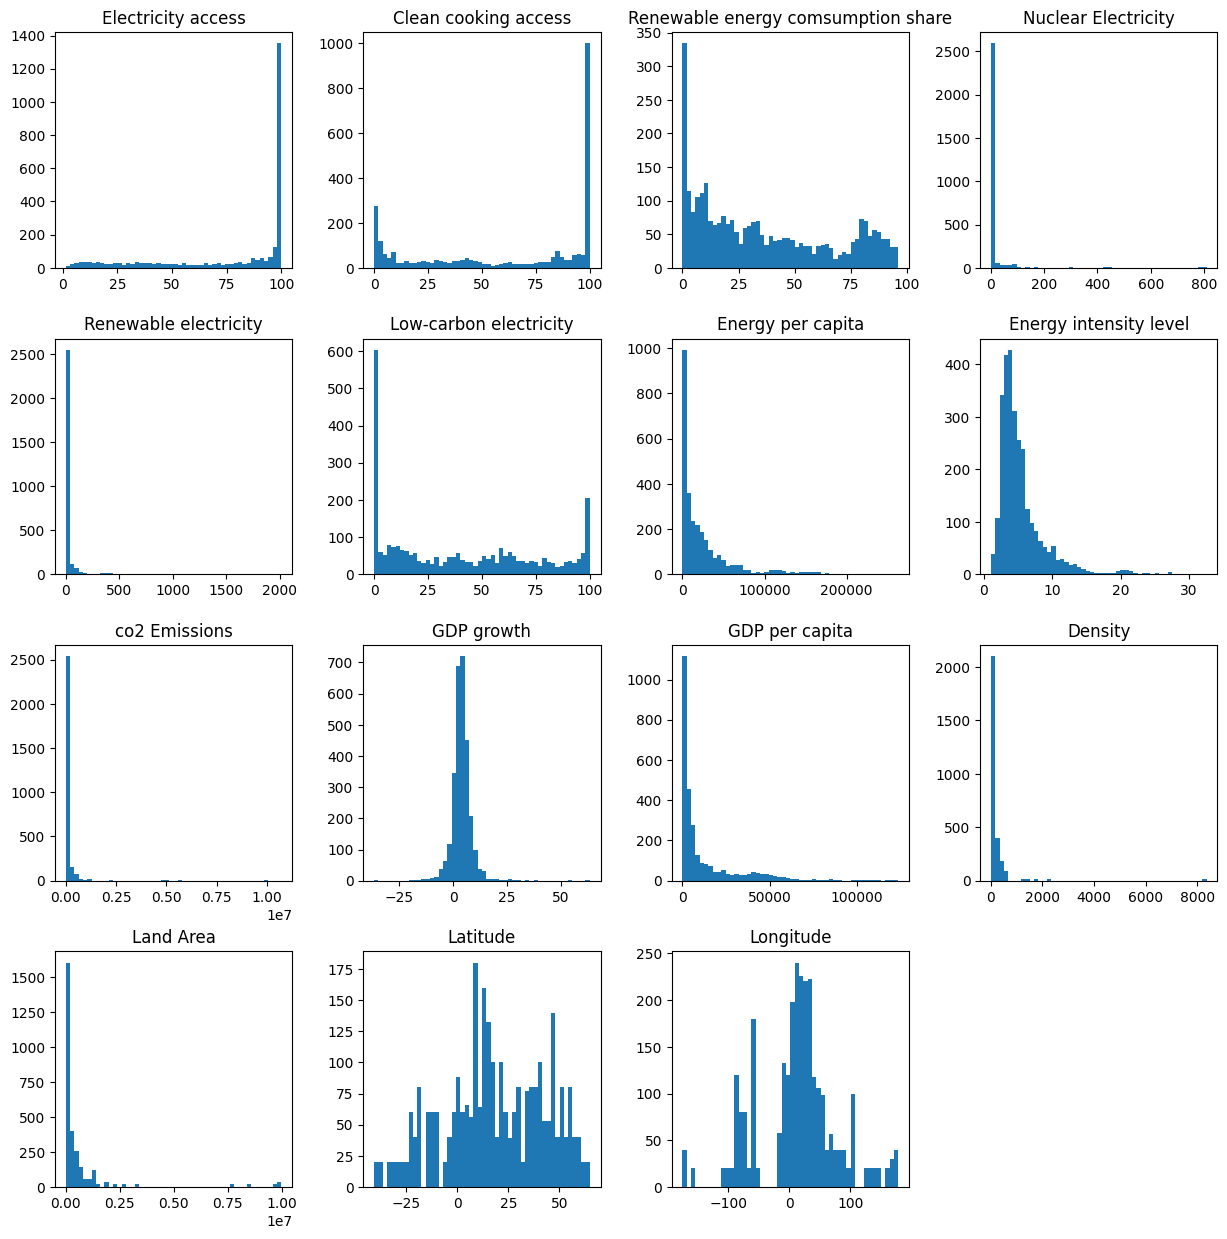

In [6]:
df.hist(figsize=(15, 15),grid=False,bins=50)
# Afficher les histogrammes
plt.show()

In [7]:
# percentage_columns = ['Electricity access', 'Clean cooking access', 'Renewable energy comsumption share', 'Low-carbon electricity']
# sqrt_columns=['Nuclear Electricity','Renewable electricity','Energy per capita','Energy intensity level','GDP per capita','Density','Land Area']

# Appliquer la transformation arcsine
# df.loc[:, percentage_columns] = df.loc[:, percentage_columns] / 100
# df.loc[:, percentage_columns] = df.loc[:, percentage_columns].apply(np.sqrt).apply(np.arcsin)

# Appliquer la fonction sqrt à ces colonnes
# df.loc[:,sqrt_columns] = df.loc[:,sqrt_columns].apply(np.sqrt)

Nous avons dans un premier temps essayé d'appliquer des transformations sur nos variables. Sur les variables exprimées en pourcentage, nous avons essayé une transformation $x\rightarrow\arcsin(x)$, afin de mieux séparer les pourcentages élevés. Sur les autres variables nous avons essayé les transformations $x\rightarrow\sqrt{x}$ et $x\rightarrow\ln(x+1)$, afin de réduire leur variance et obtenir des données "plus gaussienne" (car certains modèles font l'hypothèse de données gaussiennes pour leur fonctionnement). Mais les résultats avec ces données transformées étaient du point de vue de la performance équivalents ou moins bons. On décide alors de garder les données originales qui produisent de meilleurs résultats.

De plus, certains modèles basés sur les arbres de décision (forêts aléatoires et boosting) sont par exemple moins sensibles à l'échelle et à la distribution des données. Dans ces cas, les transformations comme la normalisation ou la standardisation ne sont pas nécessaires.

## Analyse descriptive des emissions de CO2 par pays et par années

#### Par pays

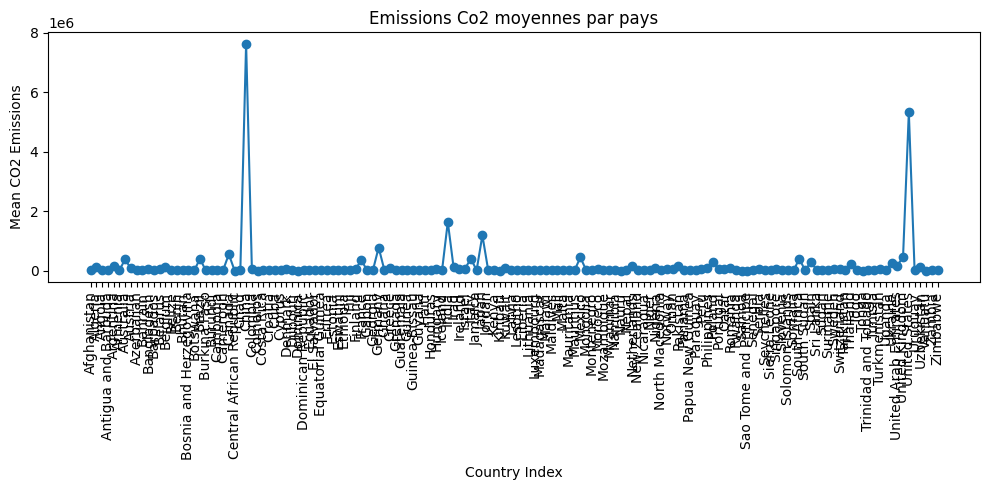

In [8]:
co2_means = {}
countries = np.unique(df['Entity'])
years = np.unique(df['Year'])

# Calcul moyenne emissions
for country in countries:
    subset = df[df['Entity'] == country]['co2 Emissions']
    co2_means[country] = subset.mean()

# Plot
indices = range(len(countries))
values = list(co2_means.values())
plt.figure(figsize=(10, 5))
plt.plot(indices, values, marker='o')
plt.title('Emissions Co2 moyennes par pays')
plt.xlabel('Country Index')
plt.ylabel('Mean CO2 Emissions')
plt.xticks(indices, list(co2_means.keys()), rotation='vertical')
plt.tight_layout()
plt.show()

On observe qu'il y a des pays qui emettent beaucoup plus d'autres, dans le cadre de l'apprentissafe automatique il est important de prendre en compte une telle disparité dans les données, car cela peut expliquer pourquoi certains modèles peuvent avoir des difficultés à ajuster les données.

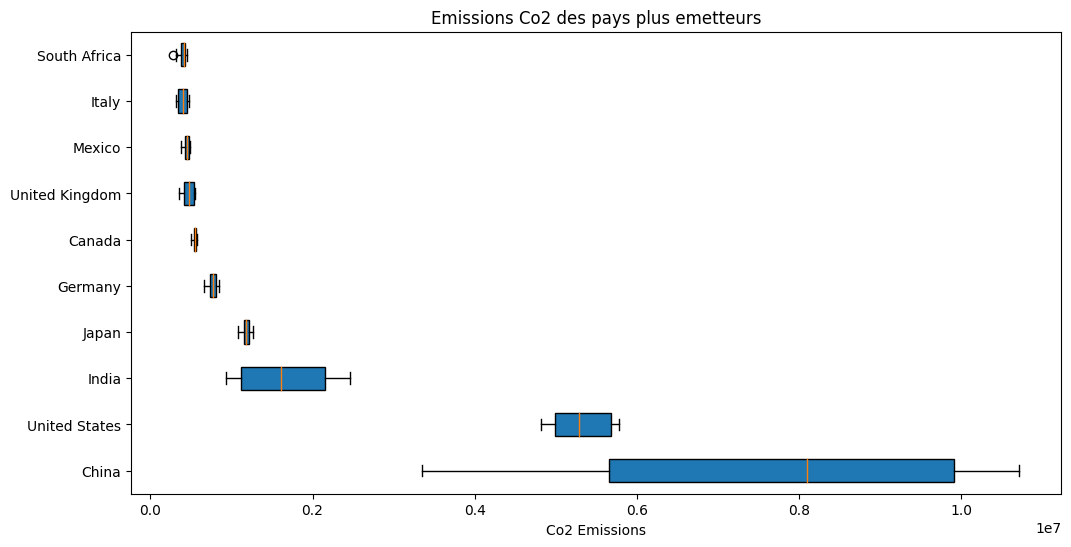

In [9]:
sorted_countries = sorted(co2_means, key=co2_means.get, reverse=True)
N = 10
top_countries = sorted_countries[:N]

# Liste pour stocker les données de chaque pays sélectionné
co2_data_top = []

for country in top_countries:
    subset = df[df['Entity'] == country]['co2 Emissions']
    co2_data_top.append(subset)

# Création du graphique à boîtes
plt.figure(figsize=(12, 6))
plt.boxplot(co2_data_top, vert=False, patch_artist=True)
plt.yticks(np.arange(1, len(top_countries) + 1), top_countries)
plt.xlabel('Co2 Emissions')
plt.title('Emissions Co2 des pays plus emetteurs')
plt.show()

Sans suprises, parmi les pays les plus emetteurs on retrouve la Chines, les USA, l'Inde.. la majorité des pays développés et pays émergents.

#### Par années

Correlation between Years and co2: 0.9646219040291235


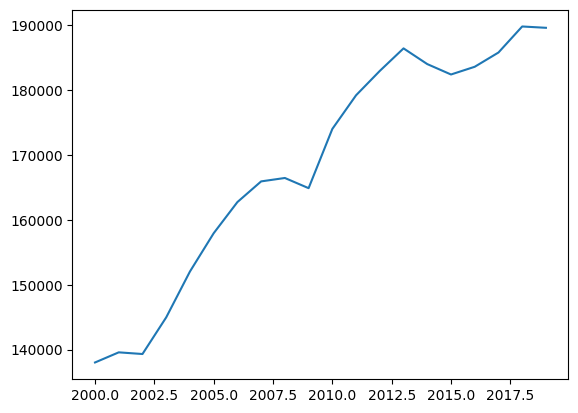

In [10]:
co2=[]

for year in years:
    subset = df['Year'] == year
    co2.append(df.loc[subset, 'co2 Emissions'].mean())

plt.plot(years,co2)
plt.plot()

correlation = np.corrcoef(years, co2)[0, 1]
print("Correlation between Years and co2:", correlation)

Comme nous pouvons le constater, les émissions de CO2 sont clairement corrélées linéairement avec la variable année. Ajouter la variable année comme variable quantitative dans notre ensemble de données d'entraînement améliorerait considérablement les performances de la prédiction.

## Analyse bidimensionelle des données

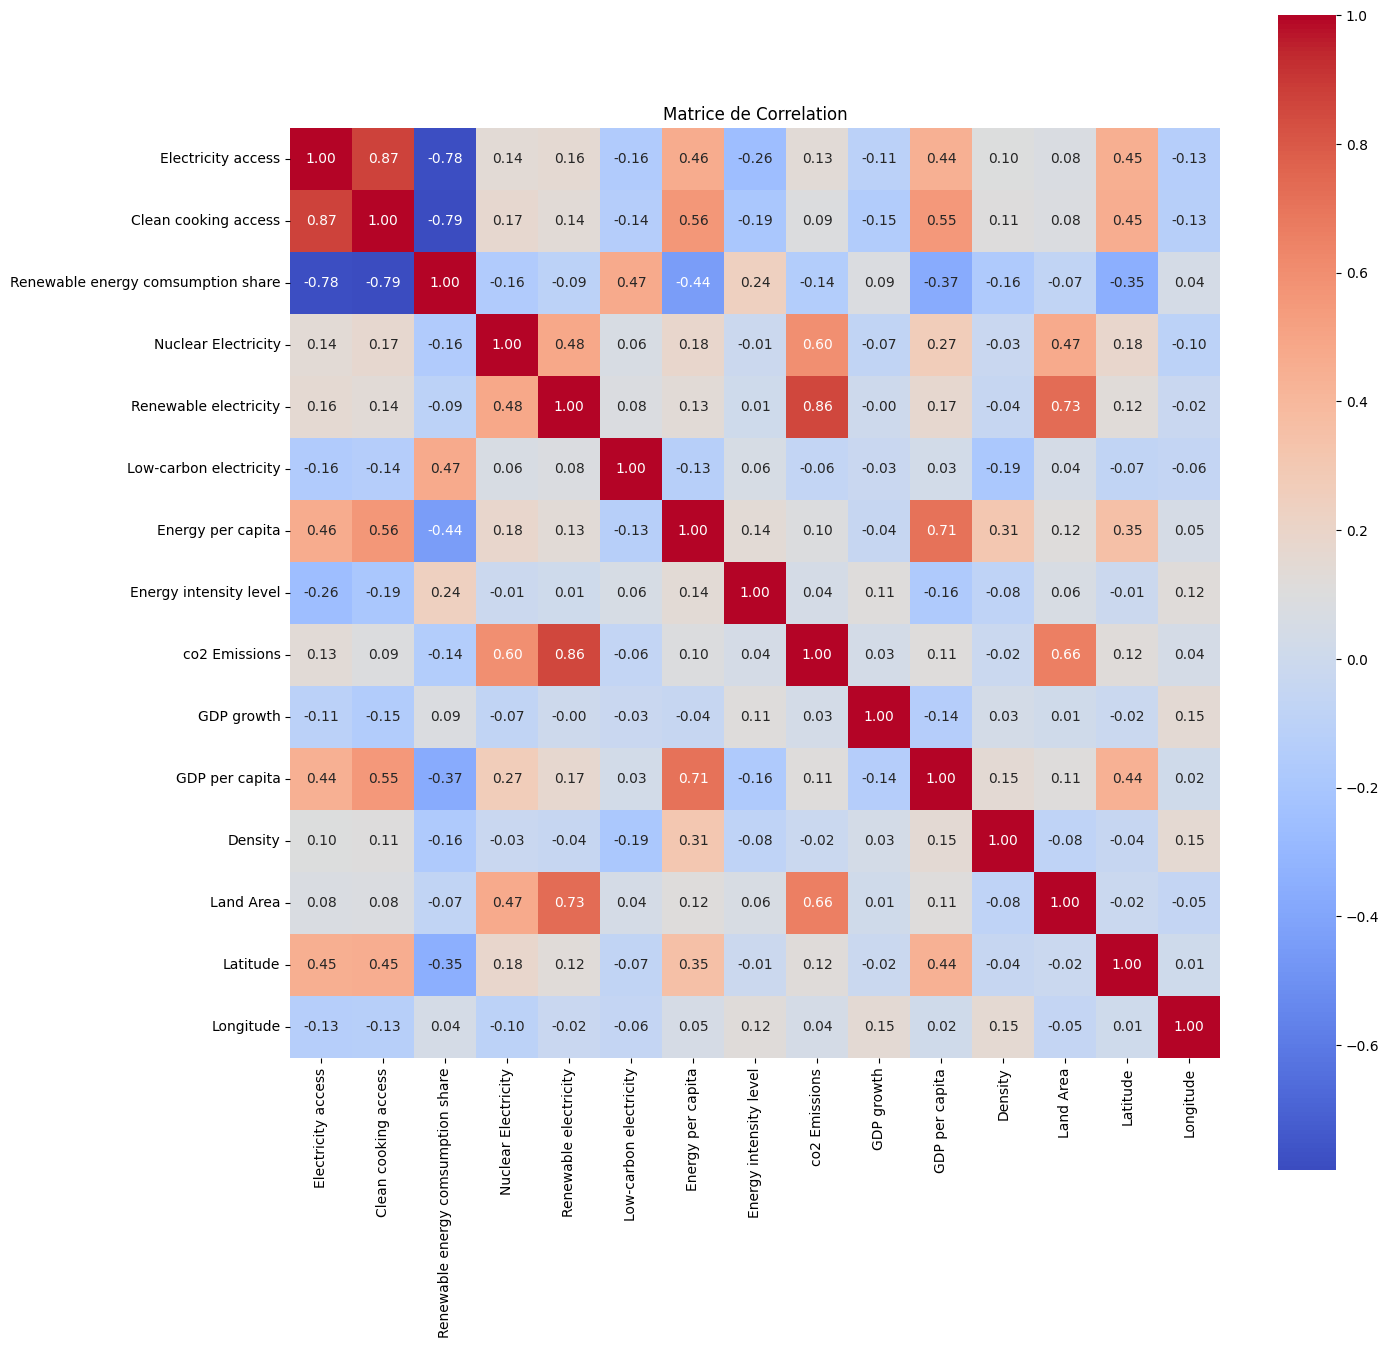

In [11]:
df_numeric = df.select_dtypes(include=['number'])
correlation_matrix = df_numeric.corr()

plt.figure(figsize=(15, 15))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", square=True)
plt.title('Matrice de Correlation')
plt.show()

Text(0.5, 1.0, 'co2 vs Land Area')

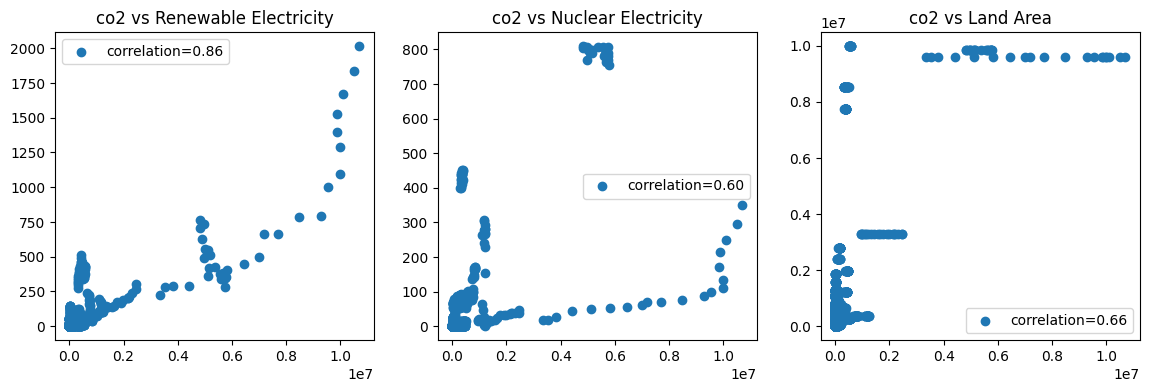

In [12]:
fig, ax =plt.subplots(1,3,figsize=(14,4))
target=df['co2 Emissions']

ax[0].scatter(target,df['Renewable electricity'])
correlation = np.corrcoef(target, df['Renewable electricity'])[0, 1]
ax[0].legend([f'correlation={correlation:.2f}'])
ax[0].set_title('co2 vs Renewable Electricity')

ax[1].scatter(target,df['Nuclear Electricity'])
correlation = np.corrcoef(target, df['Nuclear Electricity'])[0, 1]
ax[1].legend([f'correlation={correlation:.2f}'])
ax[1].set_title('co2 vs Nuclear Electricity')

ax[2].scatter(target,df['Land Area'])
correlation = np.corrcoef(target, df['Land Area'])[0, 1]
ax[2].legend([f'correlation={correlation:.2f}'])
ax[2].set_title('co2 vs Land Area')

À partir de cette matrice des corrélations, nous pouvons déjà prédire quelles variables pourraient être utilisées pour construire des estimateurs de CO2 : Nuclear electricity, Renewable electricity et Land Area qui sont les plus corrélées à la variable cible.

## Analyse multidimensionelle du jeu de données

On commence par faire une ACP sur les données quantitatives pour déséquilibrer la représentation de ces données et faire apparaître des nouvelles variables plus représentatives et on l'espère plus corrélées à la variable cible.

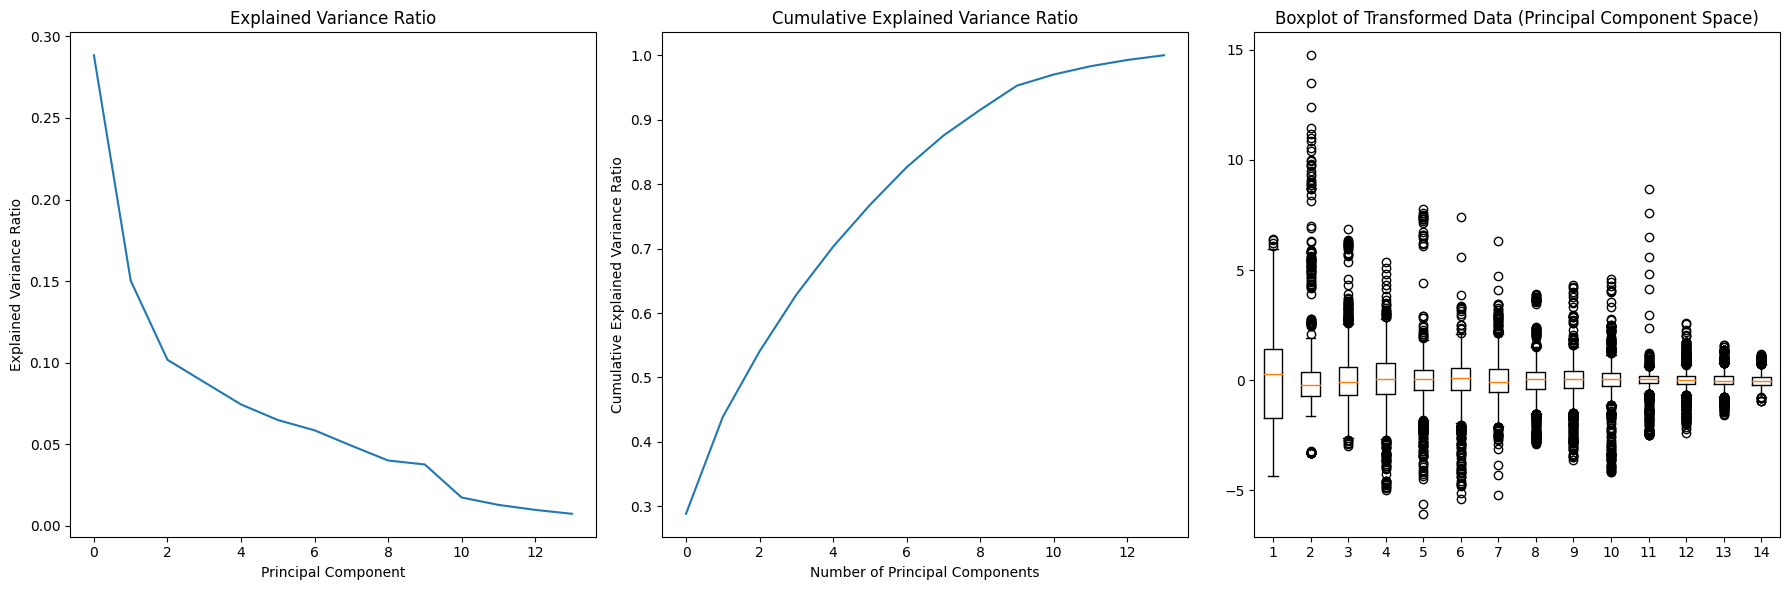

In [13]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

df_numeric.drop(columns=['co2 Emissions'],inplace=True)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_numeric)

pca = PCA()

pca.fit(X_scaled)
X_pca = pca.transform(X_scaled)

fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Explained variance ratio
axes[0].plot(pca.explained_variance_ratio_)
axes[0].set_title('Explained Variance Ratio')
axes[0].set_xlabel('Principal Component')
axes[0].set_ylabel('Explained Variance Ratio')

# Cumulative explained variance ratio
axes[1].plot(np.cumsum(pca.explained_variance_ratio_))
axes[1].set_title('Cumulative Explained Variance Ratio')
axes[1].set_xlabel('Number of Principal Components')
axes[1].set_ylabel('Cumulative Explained Variance Ratio')

# Boxplot of the transformed data in the principal component space
axes[2].boxplot(X_pca)
axes[2].set_title('Boxplot of Transformed Data (Principal Component Space)')

plt.tight_layout()
plt.show()



<ipython-input-14-3b0bd79530d4>:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  country_palette = plt.cm.get_cmap('tab10', len(countries))


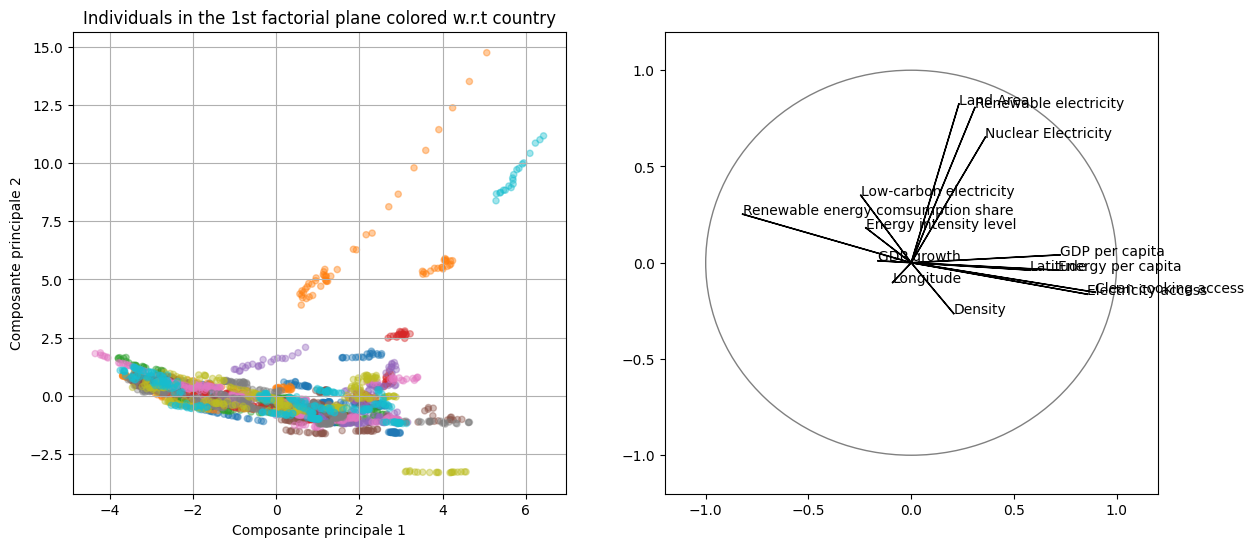

In [14]:
#On créée une palette de couleurs en fonction de la variable pays
country_palette = plt.cm.get_cmap('tab10', len(countries))
country_colormap = {country: country_palette(i) for i, country in enumerate(countries)}
country_colors=[country_colormap[x] for x in df['Entity']]

fig, ax = plt.subplots(1,2, figsize=(14,6))
ax[0].scatter(X_pca[:,0],X_pca[:,1],alpha=0.4,s=20,c=country_colors)
ax[0].grid(True)
ax[0].set_xlabel('Composante principale 1')
ax[0].set_ylabel('Composante principale 2')
ax[0].set_title('Individuals in the 1st factorial plane colored w.r.t country')

coord1=pca.components_[0]*np.sqrt(pca.explained_variance_[0])
coord2=pca.components_[1]*np.sqrt(pca.explained_variance_[1])

for i, j, nom in zip(coord1, coord2, df_numeric.columns):
    ax[1].text(i, j, nom)
    ax[1].arrow(0, 0, i, j, color='black')

# Cercle
circle = plt.Circle((0, 0), radius=1, color='gray', fill=False)
ax[1].add_artist(circle)
ax[1].set_xlim(-1.2, 1.2)
ax[1].set_ylim(-1.2, 1.2)
plt.show()

Bien sûr, les individus correspondant à un pays (correspondant à une certaine couleur) ont des valeurs assez similaires. Un regroupement plus précis en fonction des caractéristiques géographiques, par exemple, devrait être effectué pour donner du sens aux composantes principales.

Sur le graphe des variables, nous distinguons clairement les groupes de variables contribuant aux composantes principales : Fait intéressant, les variables contribuant à la deuxième composante principale (Nuclear Electricity, Renewable Electricity, Land area) sont les plus corrélées à notre variable cible.

Les variables contribuant à la première composante principale (Renewable energy comsumption share, Electricity access, Latitude, GDP per capita, Energy per capita, Clean cooking access) sont les variables suivantes qui sont les plus corrélées à la variable cible.

#### Correlations des variables originales avec la variable cible

In [15]:
correlations=correlation_matrix.loc['co2 Emissions'].abs().sort_values(ascending=False)
styled_correlations = correlations.iloc[1:].to_frame().style.background_gradient(cmap='coolwarm')
print(f'Moyenne des correlations en valeur absolue {correlations.abs().mean()}')
styled_correlations

Moyenne des correlations en valeur absolue 0.2673455266146462


,co2 Emissions
Renewable electricity,0.857375
Land Area,0.657828
Nuclear Electricity,0.597728
Renewable energy comsumption share,0.144988
Electricity access,0.133546
Latitude,0.120536
GDP per capita,0.112554
Energy per capita,0.095448
Clean cooking access,0.093662
Low-carbon electricity,0.060200


#### Correlation des composantes principales avec la variable cible

In [16]:
correlations = np.corrcoef(target, X_pca.T)[0, 1:]
correlations_df = pd.DataFrame(correlations, columns=['Correlation'])
sorted_correlations_df = correlations_df.abs().sort_values(by='Correlation', ascending=False)
sorted_correlations_df.index = [f'Principal component {index}' for index in sorted_correlations_df.index]
styled_correlations_df = sorted_correlations_df.style.background_gradient(cmap='coolwarm')
print(f'Moyenne des correlations en valeur absolue {correlations_df.abs().mean()}')
styled_correlations_df

Moyenne des correlations en valeur absolue Correlation    0.14896
dtype: float64


,Correlation
Principal component 1,0.728568
Principal component 3,0.302695
Principal component 0,0.287817
Principal component 10,0.259830
Principal component 6,0.115510
Principal component 2,0.105798
Principal component 8,0.102682
Principal component 9,0.055547
Principal component 7,0.048658
Principal component 4,0.028272


Cependant, les transformations dues à l'ACP ne semblent pas adaptées à la prédiction des émissions de CO2, car les composantes principales résultantes sont beaucoup moins corrélées à notre variable cible.

# <FONT COLOR="Red">Constitution des échantillons apprentissage/test   </font>

In [17]:
# Variables explicatives
df_dum=pd.get_dummies(df[["Year","Entity"]])
dfC=pd.concat([df_dum,df_numeric],axis=1)
dfP = np.concatenate((X_pca, df_dum.to_numpy()), axis=1)


# Variable à expliquer
y=df['co2 Emissions']

On se retrouve avec 3 datasets différents que l'on utilisera pour chacun des modèles :
* df_numeric : Les données originales, uniquement les variables quantitatives.
* dfC : Les données originales, agrémentées des variables qualitative encodées en one-hot.
* dfP : Les données transformées par l'ACP, avec les variables qualitatives en one-hot.

In [18]:
from sklearn.model_selection import train_test_split

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(df_numeric, y, test_size=0.2, random_state=42)
Xd_train, Xd_test, yd_train, yd_test = train_test_split(dfC, y, test_size=0.2, random_state=42)
Xp_train, Xp_test, yp_train, yp_test = train_test_split(dfP, y, test_size=0.2, random_state=42)


On découpe chacun de ces dataset en échantillons apprentissage/test. Ce découpage en échantillon d'entraînement et ensemble de test permettra d'obtenir une estimation de l'erreur de généralisation, qui est un indicateur de performance.

In [19]:
from sklearn.preprocessing import StandardScaler

scaler_1 = StandardScaler()

scaler_1.fit(X_train)
X_train = scaler_1.transform(X_train)
X_test = scaler_1.transform(X_test)

scaler_2 = StandardScaler()
scaler_2.fit(Xd_train)
Xd_train = scaler_2.transform(Xd_train)
Xd_test = scaler_2.transform(Xd_test)

scaler_3 = StandardScaler()
scaler_3.fit(Xp_train)
Xp_train = scaler_3.transform(Xp_train)
Xp_test = scaler_3.transform(Xp_test)

In [20]:
# Creation d'un dictionnaire pour les resultats
predictions = {}

####
Dans notre analyse, nous allons essayer de comparer les performances de différents algorithmes d'apprentissage automatique qui serontentrainéss sur les ensembles de données suivants : [variables uniquement quantitatives], [données originales + variables indicatrices] et [données PCA + variables indicatrices]

# <FONT COLOR="Red">Regression Linéaire   </font>

#### Régression linéaire sur df_numeric

MSE= 134374354776.34827
R2= 0.7930319098559885


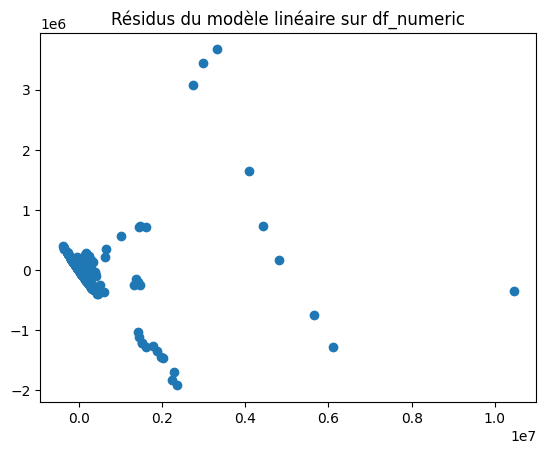

In [21]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

model = LinearRegression()

# Entrainement
linearmodel=model.fit(X_train, y_train)

# Predictions
y_pred = linearmodel.predict(X_test)

# evalutation de la performance
mse=mean_squared_error(y_test, y_pred)
print('MSE=',mse)
print("R2=",r2_score(y_test,y_pred))

# Afficher les résidus
plt.scatter(y_pred,y_test-y_pred)
plt.title('Résidus du modèle linéaire sur df_numeric')
plt.show()

[]

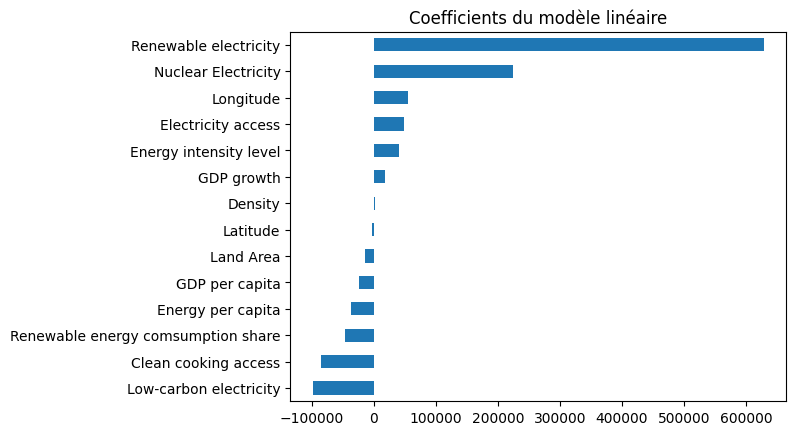

In [22]:
coef = pd.Series(linearmodel.coef_, index = df_numeric.columns)
sorted_coef= coef.sort_values()
sorted_coef.plot(kind = "barh")
plt.title(u"Coefficients du modèle linéaire")
plt.plot()

Nous aurions pu prédire facilement ce résultat, car nous avons déjà constaté dans la matrice de corrélation que la variable "Renewable electricity" était fortement corrélée linéairement à la variable cible. Les autres coefficients les plus élevés correspondent également aux variables les plus corrélées à la variable cible.

#### Regression linéaire sur dfC

MSE= 11719991197.157751
R2= 0.981948458851262


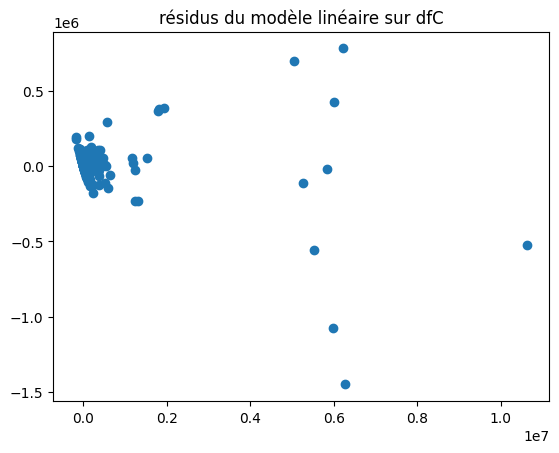

In [23]:
#linear model on data with dummies
Dumlinearmodel=model.fit(Xd_train, yd_train)

yd_pred = Dumlinearmodel.predict(Xd_test)

# Evaluate the model performance
mse=mean_squared_error(yd_test, yd_pred)
print('MSE=',mse)
print("R2=",r2_score(yd_test,yd_pred))
predictions['LinearDum']=yd_pred

# Afficher les résidus
plt.scatter(yd_pred,yd_test-yd_pred)
plt.title('résidus du modèle linéaire sur dfC')
plt.show()


Sur les deux graphiques des résidu précédentss, les données ne suivent clairement pas une distribution gaussienne i.i.d, mais à part les points de données avec des valeurs élevées de CO2 qui sont difficiles à prédire, l'ajustement est relativement bo, surtout en ajoutant les variables qualitativesn.

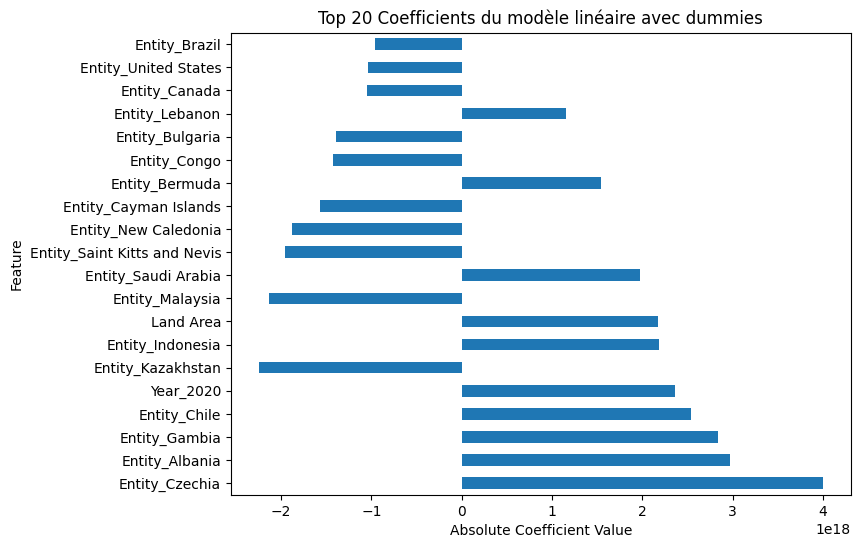

In [24]:
coef = pd.Series(Dumlinearmodel.coef_, index=dfC.columns)
sorted_coef = coef.abs().sort_values(ascending=False)

# Select the top 20 coefficients with the highest absolute values
top_20_indices = sorted_coef.head(20).index

# Get the corresponding coefficients from the original series
top_20_coef = coef.loc[top_20_indices]

# Plot the selected coefficients
plt.figure(figsize=(8, 6))  # Adjust figure size as needed
top_20_coef.plot(kind="barh")
plt.title("Top 20 Coefficients du modèle linéaire avec dummies")
plt.xlabel("Absolute Coefficient Value")
plt.ylabel("Feature")
plt.show()

Lorsque nous ajoutons les variables qualitatives en one-hot, le modèle linéaire présente des performances vraiment bonnes. En ajoutant près de 200 dummies, nous rendons le modèle linéaire beaucoup plus riche et flexible. Fondamentalement, la prédiction pour un individu donné est en grande partie portée par les valeurs des variables qualitatives Entity et Year (un modèle qui prédit la moyenne des émissions de CO2 pour l'année et le pays correspondant serait déjà un estimateur assez précis en soi).

Un problème a cela est que l'on ne peut pas prédire pour un nouveau pays qui n'est pas dans la base de données. De pluse nous perdons toute forme d'interprétabilité, ce qui est le principal avantage de la régression linéaire. Pour éviter ce type d'ajustement, nous effectuons une régression Lasso sur le même ensemble de données dans la section suivante, ce qui pénalise les amplitudes des coefficients.

In [25]:
PCAmodel=model.fit(Xp_train, yp_train)
yp_pred=PCAmodel.predict(Xp_test)
print(f'R2 score = {r2_score(yp_test,yp_pred)}')

R2 score = 0.9104346219617219


En utilisant les données issues de l'ACP (dfP) nous pouvons obtenir des résultats similaires, mais comme nous ne savons pas ce que représentent exactement les composantes principales, il n'est pas utile d'utiliser les données de l'ACP pour la régression Lasso dont l'intérêt est son interprétabilité.

# <FONT COLOR="Red"> Regression Lasso  </font>

#### Regression Lasso sur df_numeric

In [26]:
from sklearn.model_selection import GridSearchCV
from sklearn import linear_model
# grille de valeurs du paramètre alpha à optimiser
param=[{"alpha":[0.1,1,10,100,1000,2000]}]
regLasso = GridSearchCV(linear_model.Lasso(random_state=42), param,cv=5,n_jobs=-1)
regLassoOpt=regLasso.fit(X_train, y_train)

# paramètre optimal
print("Meilleur paramètre = %s",regLassoOpt.best_params_)

Meilleur paramètre = %s {'alpha': 2000}


On optimise la valeur du paramètre de pénalisation alpha sur une grille de valeurs par validation croisée et on obtient les prédictions suivantes avec le modèle optimal :

MSE= 134505024233.05379
r2 score = 0.792830648179685


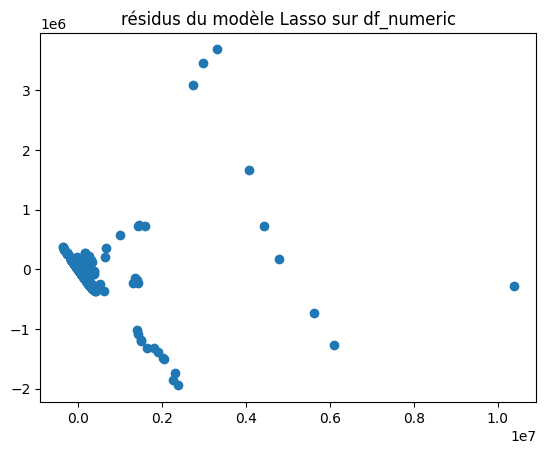

In [27]:
# Prédiction avec le modèle optimal
y_pred=regLassoOpt.predict(X_test)

mse=mean_squared_error(y_pred,y_test)
print("MSE=",mse)
print("r2 score =", r2_score(y_test,y_pred))
# Afficher les résidus
plt.scatter(y_pred,y_test-y_pred)
plt.title('résidus du modèle Lasso sur df_numeric')
plt.show()

Niveau performance, on observe pas de différence notable avec la regréssion linéaire sur df_numeric

[]

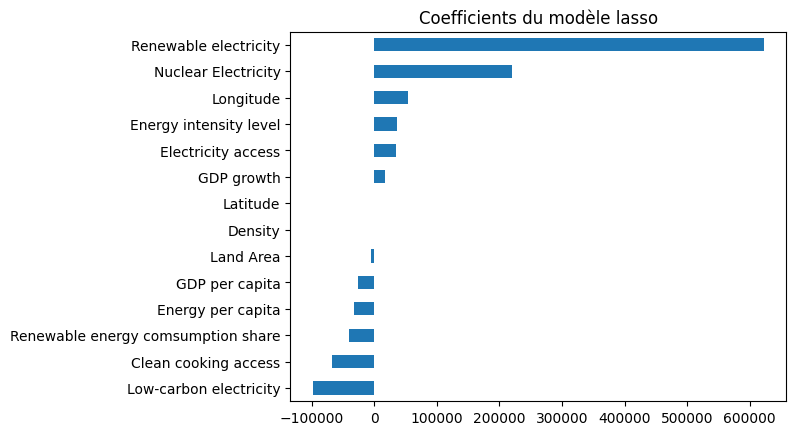

In [28]:
coef = pd.Series(regLassoOpt.best_estimator_.coef_, index = df_numeric.columns)
sorted_coef= coef.sort_values()
sorted_coef.plot(kind = "barh")
plt.title(u"Coefficients du modèle lasso")
plt.plot()

En pénalisant la norme 1 des coefficients, la régression Lasso effectue une sélection des variables. L'optimisation du paramètre alpha à travers la validation croisée permet d'introduire la pénalisation optimale, ce qui opère une sélection de modèle. Ici, le modèle Lasso optimal élimine essentiellement les variables de densité, d'énergie par habitant et de longitude, tout en réduisant l'intensité de la plupart des autres coefficients. Cependant, nous observons que le coefficient de l'électricité fossile reste inchangé.

Pour ce jeu de données, à part annuler l'influence de certaines variables qui étaient déjà peu importantes on ne change pas grand-chose par rapport au modèle linéaire.

#### Regressions Lasso sur dfC

In [29]:
from sklearn.model_selection import GridSearchCV
# grille de valeurs du paramètre alpha à optimiser
param=[{"alpha":[0.1,1,10,100,1000,2000]}]
regLassoDum = GridSearchCV(linear_model.Lasso(random_state=42), param,cv=5,n_jobs=-1)
regLassoOptDum=regLassoDum.fit(Xd_train, yd_train)

# paramètre optimal
print("Meilleur paramètre = %s",regLassoOptDum.best_params_)

Meilleur paramètre = %s {'alpha': 10}


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.238e+12, tolerance: 1.546e+11
  model = cd_fast.enet_coordinate_descent(


MSE= 11539959915.018456
R2= 0.9822257493408987


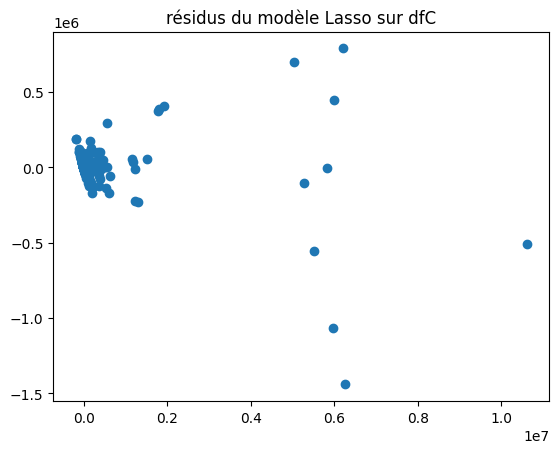

In [30]:
#Prédictions
yd_pred = regLassoOptDum.predict(Xd_test)

#performances
mse=mean_squared_error(yd_test, yd_pred)
print('MSE=',mse)
print("R2=",r2_score(yd_test,yd_pred))

predictions['LassoDum']=yd_pred

# Afficher les résidus
plt.scatter(yd_pred,yd_test-yd_pred)
plt.title('résidus du modèle Lasso sur dfC')
plt.show()

Niveau performance, on observe pas de différence notable avec la regréssion linéaire sur dfC.

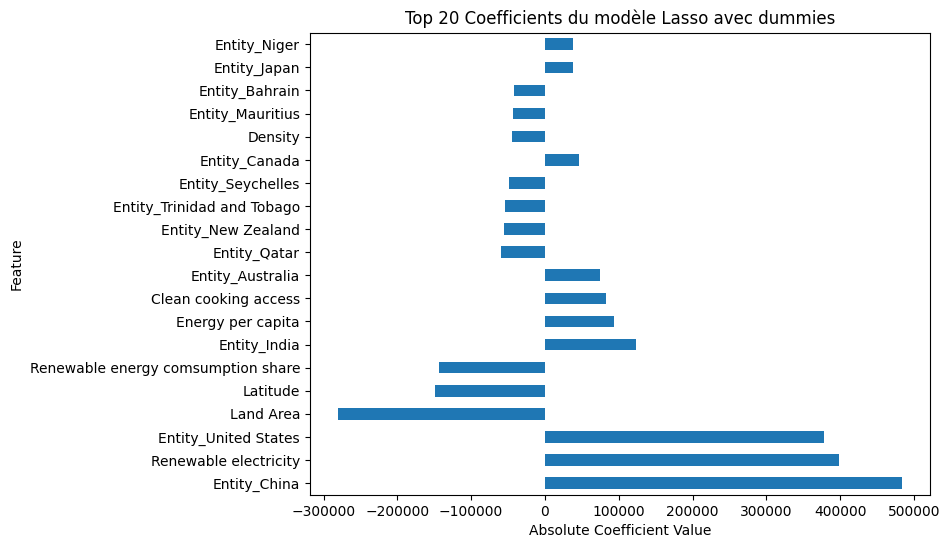

In [31]:
coef = pd.Series(regLassoOptDum.best_estimator_.coef_, index=dfC.columns)
sorted_coef = coef.abs().sort_values(ascending=False)

# Select the top 20 coefficients with the highest absolute values
top_20_indices = sorted_coef.head(20).index

# Get the corresponding coefficients from the original series
top_20_coef = coef.loc[top_20_indices]

# Plot the selected coefficients
plt.figure(figsize=(8, 6))  # Adjust figure size as needed
top_20_coef.plot(kind="barh")
plt.title("Top 20 Coefficients du modèle Lasso avec dummies")
plt.xlabel("Absolute Coefficient Value")
plt.ylabel("Feature")
plt.show()

Avec l'ensemble de données contenant les dummies, la régression Lasso fonctionne toujours aussi bien qu'en régression linéaire. Maintenant que les amplitudes des coefficients sont contraintes, nous obtenons des résultats beaucoup plus compréhensibles.

Sans surprises, la variable Renewable electricity porte à nouveau beaucoup de poids. Mais lorsque nous ajoutons les dummies, l'explication derrière le modèle est vraiment différente, on observe que ce sont de nouvelles variables qui ont de l'importance : Latitude et Land Area alors qu'elles étaient éliminées dans le modèle précédent.

C'est une combinaison entre les "Country" dummies et des variables géographiques (Latitude, Land area) qui explique la répartition des emissions de co2. Ce modèle est un peu similaire à la régression linéaire avec dummies et sans pénalisation qui n'est pas forcément adapté pour la prédiction pour un nouveau pays par exemple.


La limite avec les modèles linéaires est que la précision dépend uniquement de vos données elles-mêmes étant linéaires (proches d'un hyperplan dans l'espace des caractéristiques). À en juger par le graphique des résidus, les données ne sont pas totalement linéaires dans notre cas.

# <FONT COLOR="Red">Regression à vecteurs supports (SVR) </font>

#### SVR sur dfC

In [32]:
from sklearn.svm import SVR
# param={'epsilon' :[0.01,0.1,10,1000], 'C':[1,100,1e4,1e7], 'degree':[2,3,4]}
# svrOpt=GridSearchCV(SVR(kernel='poly'),param,cv=5,n_jobs=-1)
# dum_svm=svrOpt.fit(Xd_train,yd_train)
# yd_pred=dum_svm.predict(Xd_test)
# print(svrOpt.best_params_)
# print(f"Original data : MSE= {mean_squared_error(yd_pred,yd_test)}, r2= {r2_score(yd_pred,yd_test)}")

Ici, nous exécutons uniquement le SVR avec des paramètres spécifiés qui ont été optimisés par validation croisée au préalable :
* Paramètre C : Paramètre de régularisation. La force de la régularisation est inversement proportionnelle à C.
* Paramètre epsilon : Spécifie la largeur du tube epsilon autour de la marge. Cela détermine la marge d'erreur tolérée pour les prédictions.
* Paramètre kernel : Noyau utilisé, correspond à l'espace à grande dimension dans lequel on effectue la regression. Contrôle donc le type de la frontière d'ajustement une fois représentée dans le plan original (polynomiale, exponentielle..).
* Paramètre degree : Donne le degré de la fonction noyau polynomiale.

_La calibration d'une svr sur df_numeric au début de la cellule suivante peut prendre environ 5 minutes_

In [33]:
svr=SVR(C=1e7,epsilon=0.01,degree=3,kernel='poly',max_iter=10000)
svm=svr.fit(X_train,y_train)
y_pred=svm.predict(X_test)
print(f"Dummies data : MSE= {mean_squared_error(y_pred,y_test)}, r2= {r2_score(y_test,y_pred)}")

svrd=SVR(C=1e7,epsilon=0.01,degree=3,kernel='poly')
dum_svm=svrd.fit(Xd_train,yd_train)
yd_pred=dum_svm.predict(Xd_test)
print(f"Dummies data : MSE= {mean_squared_error(yd_pred,yd_test)}, r2= {r2_score(yd_test,yd_pred)}")

svrp=SVR(C=1e7,epsilon=0.01,degree=3,kernel='poly')
pca_svm=svrp.fit(Xp_train,yp_train)
yp_pred=pca_svm.predict(Xp_test)
print(f"PCA data : MSE= {mean_squared_error(yp_pred,yp_test)}, r2= {r2_score(yp_test,yp_pred)}")

/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Dummies data : MSE= 11063661510.322807, r2= 0.982959360834867
Dummies data : MSE= 9030487460.382952, r2= 0.9860909267556619
PCA data : MSE= 7444521030.92021, r2= 0.9885336878277783


La calibration d'un modèle de régression à vecteurs supports sur df_numeric produit des prédictions excellentes, mais est très couteuse. On propose alors aussi une calibration sur les données supplémentées des variables qualitatives qui montrent des résultats très bons et un temps d'éxecution bien plus court.

#### <span style="color: blue;">On prédit séparément avec la SVR sur df_numeric et sur dfP </span>

MSE= 11063661510.322807
r2 score = 0.982959360834867


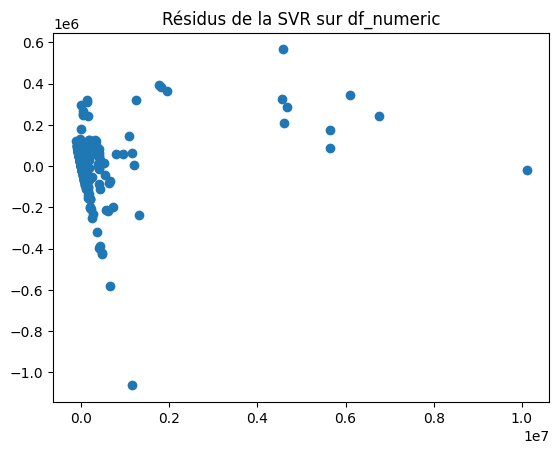

In [34]:
# Prédiction avec le modèle optimal
y_pred=svr.predict(X_test)
mse=mean_squared_error(y_pred,y_test)
print("MSE=",mse)
print("r2 score =", r2_score(y_test,y_pred))
predictions['SVMquanti']=y_pred

# Afficher les résidus
plt.scatter(y_pred,y_test-y_pred)
plt.title("Résidus de la SVR sur df_numeric")
plt.show()

MSE= 7444521030.92021
r2 score = 0.9885336878277783


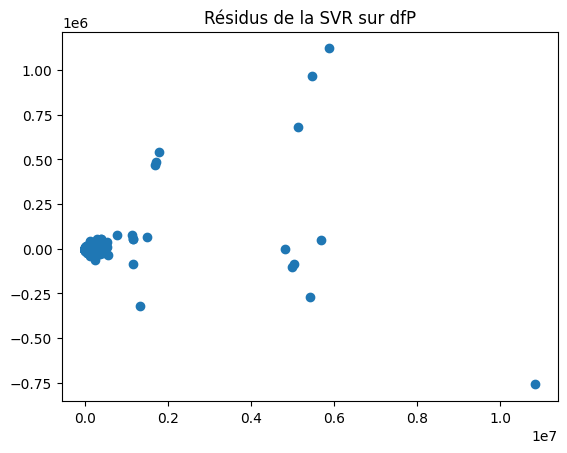

In [35]:
# Prédiction avec le modèle optimal
yp_pred=svrp.predict(Xp_test)
mse=mean_squared_error(yp_pred,yp_test)
print("MSE=",mse)
print("r2 score =", r2_score(yp_test,yp_pred))
predictions['SVMquali']=yp_pred

# Afficher les résidus
plt.scatter(yp_pred,yp_test-yp_pred)
plt.title("Résidus de la SVR sur dfP")
plt.show()

Parmi tous les noyaux, le polynomial semble produire les meilleurs résultats. Cela a du sens car la relation entre les caractéristiques d'entrée et la variable cible est presque linéaire (bonnes performances des modèles linéaires) et peut donc être bien approximée par une fonction polynomiale. En revanche, les autres noyaux sont généralement plus flexibles et utilisés pour capturer des relations beaucoup moins linéaires.

Dans notre situation, la validation croisée nous donne une valeur élevée du paramètre C : théoriquement, augmenter C impose une faible erreur de prédiction sur les ensembles de données d'entraînement mais peut causer du surajustement. Cependant, les données étant relativement linéaires et régulières, cette valeur de C permet un ajustement plus précis aux données d'entraînement sans sacrifier les performances de généralisation.

Cependant, plus la valeur du paramètre C est élevée, plus la surface de prédiction (correspondant à l'hyperplan dans l'espace transformé ensuite retourné dans l'espace des caractériques) est complexe car elle doit s'ajuster plus étroitement aux données. Ajuster cette surface avec une valeur élevée de C semble entraîner des coûts de calcul plus élevés.

# <FONT COLOR="Red">Arbres de Regression   </font>

#### Arbre de régression sur df_numeric

Meilleur paramètre = %s {'max_depth': 9}
r2score = 0.9773227935458274


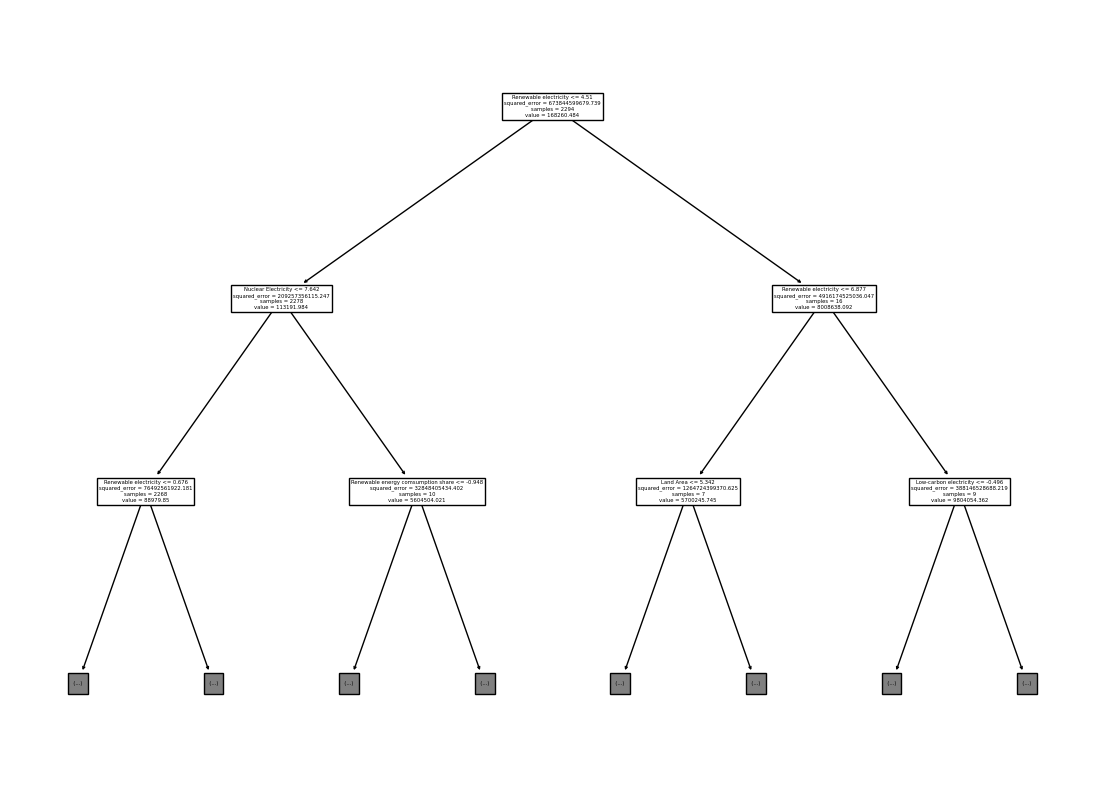

In [36]:
from sklearn.tree import plot_tree
from sklearn.tree import DecisionTreeRegressor
param=[{"max_depth":list(range(2,10))}]
tree= GridSearchCV(DecisionTreeRegressor(random_state=42),param,cv=10,n_jobs=-1)
treeOpt=tree.fit(X_train, y_train)

# paramètre optimal
print("Meilleur paramètre = %s" ,treeOpt.best_params_)
print("r2score =",r2_score(y_test,treeOpt.predict(X_test)))

best_tree = treeOpt.best_estimator_
plt.figure(figsize=(14, 10))
plot_tree(best_tree,feature_names=df_numeric.columns.tolist(),max_depth=2);

L'optimisation par validation croisée du paramètre max_depth qui contrôle le nombre de divisions dans l'arbre donne une valeur optimale égale à 7. Plus il y a de divisions plus on ajuste les données (attention au sur-ajustement).
On affiche ci-dessus les premiers niveaux de l'arbre de régression optimal sur les données df_numeric.

In [37]:
feature_importance = dict(zip(df_numeric.columns.tolist(), best_tree.feature_importances_))
sorted_features = sorted(feature_importance.items(), key=lambda x: x[1], reverse=True)

for feature, importance in sorted_features:
    print(f'{feature}, Importance: {importance}')

Renewable electricity, Importance: 0.726478030012097
Nuclear Electricity, Importance: 0.20246540294697468
Energy intensity level, Importance: 0.03569898953977164
Longitude, Importance: 0.01482634877962444
Land Area, Importance: 0.008307963089612633
Low-carbon electricity, Importance: 0.005342082970237219
Renewable energy comsumption share, Importance: 0.004211315557647249
Energy per capita, Importance: 0.0015289261484870344
Density, Importance: 0.0005542012825695832
Electricity access, Importance: 0.0003224564647678719
GDP per capita, Importance: 0.00020828955540295508
GDP growth, Importance: 4.520643151324538e-05
Clean cooking access, Importance: 1.0787221294517459e-05
Latitude, Importance: 0.0


Ajuster un arbre de régression sur des données quantitatives se fait principalement en utilisant les variables "Électricité renouvelable" et "Électricité nucléaire". Ce n'est pas suprenant étant les deux variables les plus corrélées à la variable cible.

Un arbre de régression simple comme celui-ci produit des résultats déjà très bons.


#### Arbres de régression avec ajout des variables qualitatives

In [38]:
treep= GridSearchCV(DecisionTreeRegressor(random_state=0),param,cv=10,n_jobs=-1)
treeOptp=treep.fit(Xp_train, yp_train)
print("PCA Data : Meilleur paramètre = %s",treeOptp.best_params_)
print("r2score =",r2_score(yp_test,treeOptp.predict(Xp_test)))

treed= GridSearchCV(DecisionTreeRegressor(random_state=2),param,cv=10,n_jobs=-1)
treeOptd=treed.fit(Xd_train, yd_train)
print("Dummies data : Meilleur paramètre = %s",treeOptd.best_params_)
print("r2score =",r2_score(yp_test,treeOptd.predict(Xd_test)))

PCA Data : Meilleur paramètre = %s {'max_depth': 9}
r2score = 0.9583055816418402
Dummies data : Meilleur paramètre = %s {'max_depth': 8}
r2score = 0.9570276639830405


In [39]:
best_treed = treeOptd.best_estimator_
feature_importance = dict(zip(dfC.columns.tolist(), best_treed.feature_importances_))
sorted_features = sorted(feature_importance.items(), key=lambda x: x[1], reverse=True)
for feature, importance in sorted_features[:20]:
    print(f'{feature}, Importance: {importance}')

Renewable electricity, Importance: 0.712278566843897
Entity_United States, Importance: 0.19657785722230645
Entity_China, Importance: 0.05090713419650437
Longitude, Importance: 0.016412495047431138
Nuclear Electricity, Importance: 0.006270194818874782
GDP growth, Importance: 0.006149347394985457
Latitude, Importance: 0.002801043429566847
Land Area, Importance: 0.0023044646353667757
Entity_South Africa, Importance: 0.001455122873467123
Entity_Germany, Importance: 0.0010354480973487428
Entity_Italy, Importance: 0.0008440842618232962
Density, Importance: 0.0008289616481408122
GDP per capita, Importance: 0.0005592406192047363
Low-carbon electricity, Importance: 0.0005021753018134252
Renewable energy comsumption share, Importance: 0.00039802212052119225
Energy per capita, Importance: 0.0003308459943677279
Year_2004, Importance: 0.00016308855496699294
Energy intensity level, Importance: 9.027073505920381e-05
Clean cooking access, Importance: 8.24410662543428e-05
Year_2001, Importance: 9.10064

Comme nous pouvons le constater, l'ajustement d'arbres de régression lorsque des dummies sont ajoutées ne produit pas de meilleurs résultats, car les arbres de régression utilisent essentiellement les mêmes variables quantitatives qu'auparavant.

En effet, les variables dummies ne sont pas choisies car contiennent une information très spécifique n'étant pas capables de discriminer le jeu de données dans son entièreté.

On observe aussi que les variables composantes principales sont moins efficaces pour discriminer directement les données Co2 que les variables originales, ce qui est encore lié au fait qu'elles sont moins corrélées à la variable cible.

#### <span style="color: blue;">On choisit alors l'arbre de régression sur les variables quantitatives originale pour de meilleures performances</span>

MSE= 14723211598.895105
r2 score = 0.9773227935458274


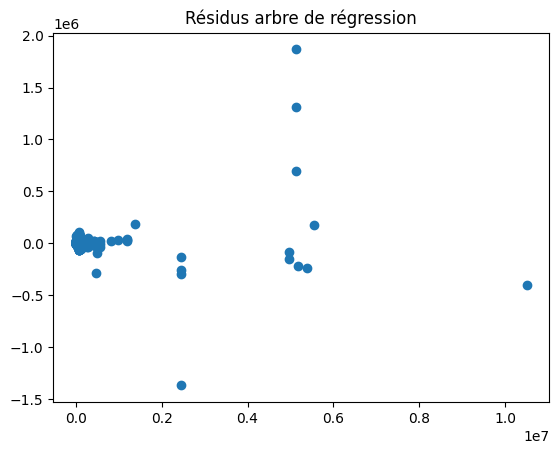

In [40]:
# Prédiction avec le modèle optimal
y_pred=treeOpt.predict(X_test)
mse=mean_squared_error(y_pred,y_test)
print("MSE=",mse)
print("r2 score =", r2_score(y_test,y_pred))
predictions['CART']=y_pred
plt.scatter(y_pred,y_test-y_pred)
plt.title('Résidus arbre de régression')
plt.show()

# <FONT COLOR="Red">Forêts aléatoires   </font>

#### Forêts aléatoires sur df_numeric

In [41]:
from sklearn.ensemble import RandomForestRegressor
param=[{"max_features":list(range(2,8,1)),"min_samples_split":list(range(2,8,1)),"n_estimators":[10,25,50]}]

rf=GridSearchCV(RandomForestRegressor(random_state=3),param,cv=5,n_jobs=-1)
rfOpt=rf.fit(X_train,y_train)

print("Meilleur paramètre = %s",rfOpt.best_params_)
print("r2score =",r2_score(y_test,rfOpt.predict(X_test)))

Meilleur paramètre = %s {'max_features': 5, 'min_samples_split': 2, 'n_estimators': 10}
r2score = 0.9898860597625031


On optimise par validation croisée les paramètres de la forêt aléatoire :
* Paramètre max_features : Le nombre maximum de caractéristiques à considérer lors de la recherche de la meilleure scission.
* Paramètre max_depth : La profondeur maximale de chaque arbre de décision. Contrôle le trade-off biais variance.
* Paramètre n_estimators : Le nombre d'arbres composant la forêt.

In [42]:
best_forest = rfOpt.best_estimator_

feature_importance = dict(zip(df_numeric.columns.tolist(), best_forest.feature_importances_))
sorted_features = sorted(feature_importance.items(), key=lambda x: x[1], reverse=True)

for feature, importance in sorted_features:
    print(f'{feature}, Importance: {importance}')

Land Area, Importance: 0.32530637708024324
Renewable electricity, Importance: 0.2427503618609959
Nuclear Electricity, Importance: 0.12840982170451315
Low-carbon electricity, Importance: 0.09022116084279923
Longitude, Importance: 0.05954602386681005
Renewable energy comsumption share, Importance: 0.028283750387420797
Density, Importance: 0.02726881374214739
Latitude, Importance: 0.02718509183409761
Electricity access, Importance: 0.017094134630260837
GDP per capita, Importance: 0.015339982479521086
Energy intensity level, Importance: 0.014998878602442617
Clean cooking access, Importance: 0.012055088780686913
GDP growth, Importance: 0.006154961705236567
Energy per capita, Importance: 0.005385552482824618


Les variables "Renewable electrity" et "Nuclear electricity" et "Land area" sont encore le plus souvent sélectionées car plus coréllées à la variable cible. Les autres variables sont néanmoins plus souvent utilisées : c'est l'essence du random forest qui en sélectionnant aléatoirement des variables à chaque noeud permet de construire des arbres moins corrélés pour réduire la variance de l'estimation.

#### Forêts aléatoires sur dfC

In [43]:
param=[{"max_features":list(range(2,8,1)),"min_samples_split":list(range(2,8,1))}]
rfd= GridSearchCV(DecisionTreeRegressor(random_state=42),param,cv=10,n_jobs=-1)
rfOptd=rfd.fit(Xd_train, yd_train)
print("Dummies data : Meilleur paramètre = %s",rfOptd.best_params_)
print("r2score =",r2_score(yd_test,rfOptd.predict(Xd_test)))

Dummies data : Meilleur paramètre = %s {'max_features': 4, 'min_samples_split': 4}
r2score = 0.5883192607035717


In [44]:
best = rfOptd.best_estimator_
feature_importance = dict(zip(dfC.columns.tolist(), best.feature_importances_))
sorted_features = sorted(feature_importance.items(), key=lambda x: x[1], reverse=True)
for feature, importance in sorted_features[:20]:
    print(f'{feature}, Importance: {importance}')

Entity_China, Importance: 0.4662081349326753
Longitude, Importance: 0.23981350075676325
GDP per capita, Importance: 0.06222785903108307
GDP growth, Importance: 0.061899703433805346
Clean cooking access, Importance: 0.0514892629904081
Renewable energy comsumption share, Importance: 0.03962249695797774
Nuclear Electricity, Importance: 0.01641943404016836
Entity_Netherlands, Importance: 0.01275035568013229
Land Area, Importance: 0.005888613681318588
Year_2014, Importance: 0.004836593358901709
Entity_Iceland, Importance: 0.0036035122066928288
Entity_United Kingdom, Importance: 0.003265948510048865
Entity_India, Importance: 0.002692521707703273
Low-carbon electricity, Importance: 0.00240712028913362
Year_2015, Importance: 0.0023459015698852055
Entity_Fiji, Importance: 0.0022701076492369324
Energy per capita, Importance: 0.0021869921038410083
Entity_Singapore, Importance: 0.002037361268369166
Year_2011, Importance: 0.0019094061211332807
Entity_Ukraine, Importance: 0.0015582833788758716


Parce que l'algorithme de forêt aléatoire sélectionne un petit nombre de variables au hasard parmi toutes celles disponibles pour constituer chaque noeud, l'exécution de la forêt aléatoire avec nos ensembles de données complets sélectionnera très souvent les "Country" dummies (parce qu'il y en a beaucoup par rapport aux autres variables) pour discriminer les individus à chaque noeud. Cependant, ces variables ne peuvent discriminer les individus que d'un pays à un autre et ne peuvent pas discriminer l'ensemble de données aussi bien que des variables plus générales. La meilleure variable discriminante est donc choisie beaucoup moins souvent, comme nous pouvons le voir ci-dessus, et nous obtenons de très mauvais résultats.

#### <span style="color: blue;">On choisit bien sûr la fôret aléatoire sur df_numeric pour de meilleures prédictions</span>

MSE= 6566491446.650273
r2 score = 0.9898860597625031


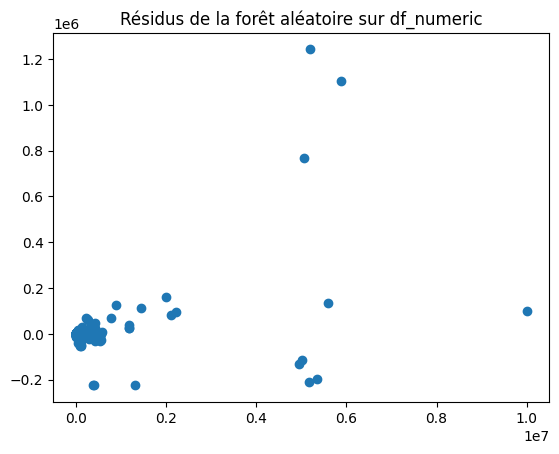

In [45]:
# Prédiction avec le modèle optimal
y_pred=rfOpt.predict(X_test)
mse=mean_squared_error(y_pred,y_test)
print("MSE=",mse)
print("r2 score =", r2_score(y_test,y_pred))
predictions['RF']=y_pred

plt.scatter(y_pred,y_test-y_pred)
plt.title('Résidus de la forêt aléatoire sur df_numeric')
plt.show()

Théoriquement, l'algorithme de forêt aléatoire fonctionne mieux que les arbres de régression, car il agrège différents arbres de régression aléatoires, ce qui diminue la variance de l'estimation.

# <FONT COLOR="Red">Boosting </font>

#### Adaboost sur df_numeric

In [46]:
from sklearn.ensemble import AdaBoostRegressor
# Create an AdaBoost regressor with a decision tree as the base estimator

param=[{"n_estimators":[5,10,50,100],"learning_rate":[0.1,1,10]}]

adaboost=GridSearchCV(AdaBoostRegressor(DecisionTreeRegressor(max_depth=9,random_state=42),random_state=10),param,cv=5,n_jobs=-1)
adaboostOpt=adaboost.fit(X_train,y_train)

print("Meilleur paramètre = ", adaboostOpt.best_params_)
print("r2score =",r2_score(y_test,adaboostOpt.predict(X_test)))

Meilleur paramètre =  {'learning_rate': 1, 'n_estimators': 10}
r2score = 0.9930581309098765


On utilise des arbres de régression comme estimateur de base et on optimise par validation croisée les paramètres de l'algorithme Adaboost :
* Paramètre learning_rate : Le taux d'apprentissage, qui contrôle la contribution de chaque estimateur faible à la mise à jour du modèle.
* Paramètre n_estimators : Le nombre d'arbres (estimateurs faibles) à estimer récursivement.

#### Adaboost avec variables qualitatives

In [47]:
adaboostp=GridSearchCV(AdaBoostRegressor(DecisionTreeRegressor(max_depth=9,random_state=42),random_state=0),param,cv=5,n_jobs=-1)
adaboostOptp=adaboostp.fit(Xp_train, yp_train)
print("PCA Data : Meilleur paramètre =",adaboostOptp.best_params_)
print("r2score =",r2_score(yp_test,adaboostOptp.predict(Xp_test)))

adaboostd=GridSearchCV(AdaBoostRegressor(DecisionTreeRegressor(max_depth=9,random_state=42),random_state=0),param,cv=5,n_jobs=-1)
adaboostOptd=adaboostd.fit(Xd_train, yd_train)
print("Dummies data : Meilleur paramètre =",adaboostOptd.best_params_)
print("r2score =",r2_score(yd_test,adaboostOptd.predict(Xd_test)))

PCA Data : Meilleur paramètre = {'learning_rate': 1, 'n_estimators': 50}
r2score = 0.9824067636393236
Dummies data : Meilleur paramètre = {'learning_rate': 1, 'n_estimators': 10}
r2score = 0.9661884433343961


Parce qu'AdaBoost est simplement une technique d'agrégation et que nos estimateurs faibles sont des arbres de régression, l'ajout des dummies n'améliore pas vraiment les performances, car les variables de discrimination importantes restent les variables quantitatives.

#### <span style="color: blue;"> On utilise encore df_numeric pour la prédiction</span>

MSE= 4507019315.287505
r2 score = 0.9930581309098765


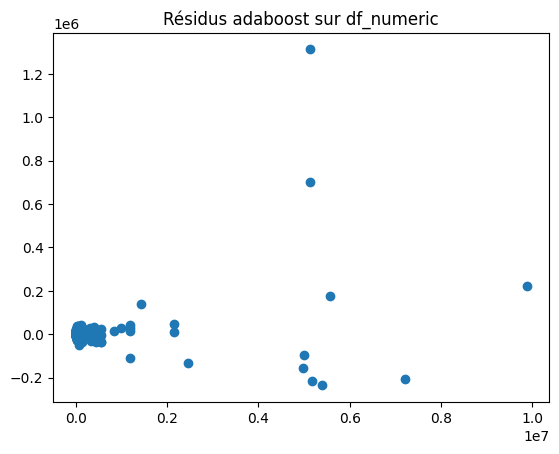

In [48]:
y_pred=adaboostOpt.predict(X_test)
mse=mean_squared_error(y_pred,y_test)
print("MSE=",mse)
print("r2 score =", r2_score(y_test,y_pred))
predictions['Adaboost']=y_pred

plt.scatter(y_pred,y_test-y_pred)
plt.title('Résidus adaboost sur df_numeric')
plt.show()

Pour tous les algorithmes que nous avons vus jusqu'à présent, la plupart des erreurs de prédiction étaient dues à un petit ensemble de points avec une valeur de CO2 élevée difficile à prédire. C'est pourquoi nous avons choisi Adaboost pour booster notre algorithme.

Adaboost entraîne plusieurs arbres de régression de manière itérative, qui sont ensuite combinés en une somme pondérée pour la sortie finale. Cet algorithme se concentre supposément davantage sur les échantillons difficiles à prédire en leur attribuant des poids plus élevés lors des itérations d'entraînement.

Les résidus ci-dessus sont très similaires à ceux donnés par l'arbre optimal simple entraîné précédemment. Les méthodes de boosting peuvent améliorer les performances des modèles de base (comme les arbres de décision), mais puisque la relation sous-jacente dans les données est simple, une seule décision optimale est déjà suffisante pour la capturer et l'agrégation ne change pas beaucoup les résultats car les régresseurs ne s'améliorent pas beaucoup étant donné qu'ils sont déjà assez optimaux. Si nous avions des données plus complexes, dans lesquelles les arbres de régression ne sont pas suffisants, nous verrions probablement les avantages des méthodes de boosting, permettant d'acquérir plus de complexité.

# <FONT COLOR="Red">Multi-layer Perceptron Regressor  </font>

#### Perceptron sur df_numeric

In [49]:
from sklearn.neural_network import MLPRegressor
param_grid=[{"hidden_layer_sizes":list(range(3,7)),'learning_rate_init':[100,10,1]}]
nnet= GridSearchCV(MLPRegressor(max_iter=10000,learning_rate='adaptive',activation="relu",random_state=42),param_grid,cv=10,n_jobs=-1)
nnetOpt=nnet.fit(X_train, y_train)

print("Meilleur paramètre = ", nnetOpt.best_params_)
print("r2score =",r2_score(y_test,nnetOpt.predict(X_test)))

Meilleur paramètre =  {'hidden_layer_sizes': 3, 'learning_rate_init': 100}
r2score = 0.9467235531580429


In [50]:
nnetI=MLPRegressor(max_iter=10000,learning_rate='adaptive',activation="identity",hidden_layer_sizes=5,learning_rate_init=10)
nnetI.fit(X_train, y_train)
print("r2score =",r2_score(y_test,nnetI.predict(X_test)))

r2score = 0.7931143378898508


Pour ce qui est de l'algorithme d'entraînement du réseau :
On fixe à 10000 le nombre d'itérations maximale de l'algorithme, et on utilise une méthode adaptative pour le taux d'apprentissage.

On a le choix entre deux fonctions d'activation, la fonction reLU ou la fonction identité.
Si on prend la fonction identité comme activation, la relation entre la sortie et l'entrée est linéaire. De ce fait, on obtient à peu près le même ajustement (r2) qu'avec un modèle linéaire. Si on prend la fonction reLU, la relation n'est plus linéaire et on est capable d'atteindre de meilleurs résultats comme pour les autres modèles non-linéaires.

On optimise par validation croisée les autres paramètres du perceptron :
* Paramètre hidden_layer_sizes :  La taille des couches cachées du réseau de neurones.
* Paramètre learning_rate_init : Le taux d'apprentissage initial.

#### Perceptron multi-couche avec ajout des variables qualitatives

In [51]:
nnetp=GridSearchCV(MLPRegressor(max_iter=10000,learning_rate='adaptive',activation="identity",random_state=2),param_grid,cv=5,n_jobs=-1)
nnetOptp=nnetp.fit(Xp_train, yp_train)
print("PCA Data : Meilleur paramètre =",nnetOptp.best_params_)
print("r2score =",r2_score(yp_test,nnetOptp.predict(Xp_test)))

nnetd=GridSearchCV(MLPRegressor(max_iter=10000,learning_rate='adaptive',activation="relu",random_state=2),param_grid,cv=5,n_jobs=-1)
nnetOptd=nnetd.fit(Xd_train, yd_train)
print("Dummies data : Meilleur paramètre = ",nnetOptd.best_params_)
print("r2score =",r2_score(yd_test,nnetOptd.predict(Xd_test)))

PCA Data : Meilleur paramètre = {'hidden_layer_sizes': 4, 'learning_rate_init': 1}
r2score = 0.9814728746340478
Dummies data : Meilleur paramètre =  {'hidden_layer_sizes': 5, 'learning_rate_init': 10}
r2score = 0.9947127608792941


L'ajout des variables qualitative améliorent la prédiction. Encore une fois, l'utilisation des données non transformées parait plus optimale.

#### <span style="color: blue;"> On utilise alors dfC pour la prédiction</span>

MSE= 3432748231.3760095
r2 score = 0.9947127608792941


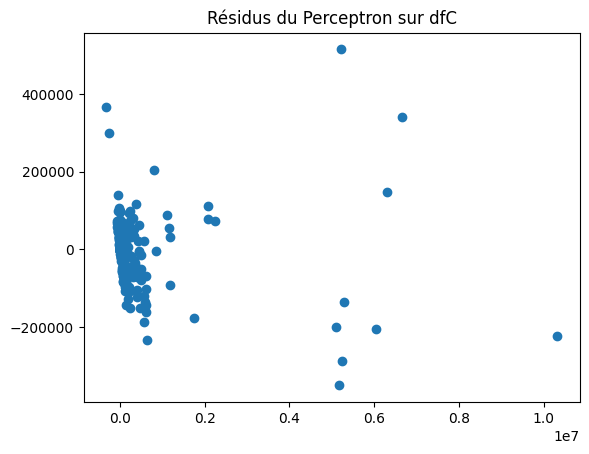

In [52]:
# Prédiction avec le modèle optimal
yd_pred=nnetOptd.predict(Xd_test)
mse=mean_squared_error(yd_pred,yd_test)
print("MSE=",mse)
print("r2 score =", r2_score(yd_test,yd_pred))
predictions['Nn']=yd_pred

plt.scatter(yd_pred,yd_test-yd_pred)
plt.title('Résidus du Perceptron sur dfC')
plt.show()

Ces perceptrons multi-couches montrent de bonnes performances. Comparés aux méthodes basées sur les arbres de régression ou les modèles linéaires, qui semblent produire de très bonnes prédictions pour les points de faible valeur de CO2 mais ont du mal avec les échantillons exceptionnels, les erreurs sur le graphique ont beaucoup moins de variance entre les points de données.

Les modèles de réseaux de neurones totalement connectés reposent sur beaucoup plus de paramètres : ici, nous avons $hidden~layer~size \times \#variables + 2 \times \#variables+1$  paramètres. Ils sont en conséquences plus lourd à estimer et manquent d'une capacité d'interprétation.


# <FONT COLOR="Red">Comparaison des performances   </font>

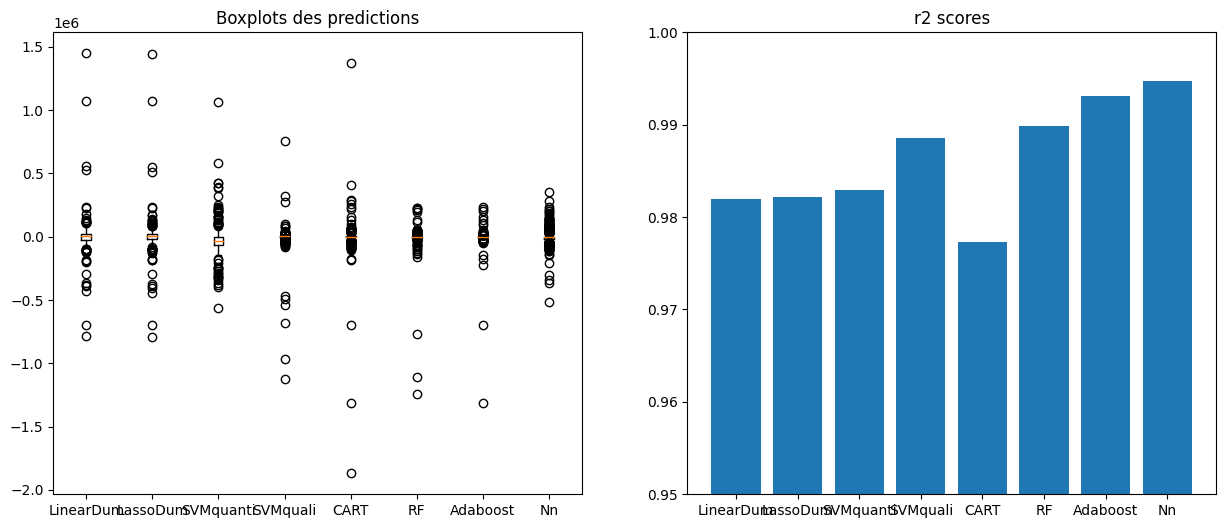

In [53]:
fig,ax=plt.subplots(1,2,figsize=(15,6))

for i, (group_name, data) in enumerate(predictions.items()):
    ax[0].boxplot(data-y_test, positions=[i + 1])

# Set the x-axis ticks and labels
ax[0].set_xticks(range(1, len(predictions) + 1))
ax[0].set_xticklabels(predictions.keys())
ax[0].set_title('Boxplots des predictions')

mses = [r2_score(y_test,data) for data in predictions.values()]
names = list(predictions.keys())

ax[1].bar(range(len(mses)), mses)
ax[1].set_title('r2 scores')
ax[1].set_xticks(range(len(mses)), names)
ax[1].set_ylim(0.95,1)

plt.show()

Les modèles linéaires constituent une méthode simple, rapide et stable qui peuvent fournir des résultats satisfaisants lorsque les relations entre les variables sont principalement linéaires. Cependant, leur performance est limitée par cette même simplicité, car ils ne peuvent pas capturer des relations plus complexes présentes dans les données. L'ajout d'une régularisation dans un modèle linéaire permet d'éviter le surajustement.
Les modèles linéaires constituent souvent un bon point de départ pour comprendre la structure des données, car ils fournissent des coefficients directement interprétables pour chaque variable.


Les modèles non linéaires, tels que les réseaux de neurones et les méthodes basées sur les noyaux ou sur des arbres offrent une plus grande flexibilité pour modéliser des relations complexes entre les variables et détectent les schéma non-linéaires. Cependant, cette flexibilité présente des inconvénients : Ils sont plus sujets au surajustement, en particulier lorsque le nombre de paramètres est élevé par rapport à la taille de l'ensemble de données. De plus, ils peuvent être plus sensibles aux problèmes de coût numérique lors de l'optimisation. Contrairement aux modèles linéaires, ils sont aussi plus difficiles à interpréter en raison de leur complexité et de la nature des transformations non linéaires qu'ils appliquent aux données.


# <FONT COLOR="Red">Handling missing data   </font>

Dans cette partie, on reprend notre dataframe avant d'avoir enlevé toutes observations ayant des valeurs manquantes et on utilise un algorithme de complétion des valeurs manquantes. L'objectif est d'observer un gain en performance pour les modèles qui se sont montrés les plus performants dans la première partie.

In [54]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.ensemble import ExtraTreesRegressor

In [55]:
#Notre dataset avant suppression des observations
dataf_numeric=dataf.select_dtypes(include=['number'])

#### Imputation avec MissForest

L'algorithme MissForest est une méthode d'imputation de données basée sur les forêts aléatoires pour prédire les valeurs manquantes dans un ensemble de données en se basant sur les valeurs observées dans les autres variables.

_Le code d'imputation suivant prend quelques minutes à s'éxecuter_

In [56]:
Imputer_rf = ExtraTreesRegressor(n_estimators=10, random_state=0)
X_Imp = IterativeImputer(estimator=Imputer_rf, random_state=0, max_iter=100).fit_transform(dataf_numeric)

/usr/local/lib/python3.10/dist-packages/sklearn/impute/_iterative.py:800: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


On utilise les données imputées pour constituer les deux jeux de données suivants :
* dataf_Imp : Les données complétées, uniquement les variables quantitatives.
* dataf_Impd : Les données quantitatives complétées agrémentées des variables qualitatives encodées en one-hot.

In [57]:
dataf_Imp=pd.DataFrame(X_Imp, columns=df.select_dtypes(include=['number']).columns)
dataf_Imp.head()

y=dataf_Imp['co2 Emissions']
dataf_Imp.drop(columns=['co2 Emissions'],inplace=True)
dataf_dum=pd.get_dummies(dataf[["Year","Entity"]])
dataf_Impd=pd.concat([dataf_dum,dataf_Imp],axis=1)

#### Dataset constitution

On créée alors de nouveaux echantillons de test et d'apprentissage sur ces jeu de données complétés.

In [58]:
from sklearn.model_selection import train_test_split

Xi_train, Xi_test, yi_train, yi_test = train_test_split(dataf_Imp, y, test_size=0.2, random_state=42)
Xj_train, Xj_test, yj_train, yj_test = train_test_split(dataf_Impd, y, test_size=0.2, random_state=42)

In [59]:
from sklearn.preprocessing import StandardScaler

scaler1 = StandardScaler()
scaler.fit(Xi_train)
Xi_train = scaler.transform(Xi_train)
Xi_test = scaler.transform(Xi_test)

scaler2 = StandardScaler()
scaler.fit(Xj_train)
Xj_train = scaler.transform(Xj_train)
Xj_test = scaler.transform(Xj_test)

### <FONT COLOR="Red">Random Forests, Adaboost, SVR, Regression Lasso, Neural networks sur le jeu de données complété </font>

In [60]:
results2={}

Pour chacun des algorithmes suivants, on utilise le dataset adapté qui produisant les meilleurs résultats d'après les analyses sur les données non-complétées :
* Pour les algorithmes basés sur des arbres, uniquement les variables quantitatives.
* Pour les autres, on ajoute les variables qualitatives.


#### Random forest sur dataf_Imp

In [61]:
param=[{"max_features":list(range(2,8,1)),"min_samples_split":list(range(2,8,1))}]

rfi=GridSearchCV(RandomForestRegressor(random_state=42),param,cv=5,n_jobs=-1)
rfOpti=rfi.fit(Xi_train,yi_train)

print("Meilleur paramètre =",rfOpti.best_params_)
print("r2score =",r2_score(yi_test,rfOpti.predict(Xi_test)))
results2["Rf"]=r2_score(yi_test,rfOpti.predict(Xi_test))

Meilleur paramètre = {'max_features': 4, 'min_samples_split': 2}
r2score = 0.9961085032241995


#### Adaboost sur dataf_Imp

In [63]:
param=[{"n_estimators":[5,10,100,1000],"learning_rate":[0.1,1,10]}]
adaboosti=GridSearchCV(AdaBoostRegressor(DecisionTreeRegressor(max_depth=9),random_state=42),param,cv=5,n_jobs=-1)
adaboostOpti=adaboosti.fit(Xi_train,yi_train)

print("Meilleur paramètre =",adaboostOpti.best_params_)
print("r2score =",r2_score(yi_test,adaboostOpti.predict(Xi_test)))
results2["Adaboost"]=r2_score(yi_test,adaboostOpti.predict(Xi_test))

Meilleur paramètre = {'learning_rate': 1, 'n_estimators': 100}
r2score = 0.9940592428090979


#### SVR sur dataf_Impd

In [64]:
svri=SVR(C=1e7,epsilon=0.01,degree=3,kernel='poly')
imp_svm=svri.fit(Xj_train,yj_train)

print("r2 score =", r2_score(yj_test,imp_svm.predict(Xj_test)))
results2["SVR"]=r2_score(yj_test,imp_svm.predict(Xj_test))

r2 score = 0.9902844900971095


#### Regression Lasso sur dataf_Impd

In [65]:
from sklearn.model_selection import GridSearchCV
param=[{"alpha":[0.1,1,10,100,1000,2000]}]
regLassoDumi = GridSearchCV(linear_model.Lasso(random_state=42), param,cv=5,n_jobs=-1)
regLassoOptDumi=regLassoDumi.fit(Xj_train, yj_train)

print("r2 score =", r2_score(yj_test,regLassoOptDumi.predict(Xj_test)))
results2["Lasso"]=r2_score(yj_test,regLassoOptDumi.predict(Xj_test))

r2 score = 0.9714226834498727


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.538e+12, tolerance: 1.853e+11
  model = cd_fast.enet_coordinate_descent(


#### MLP sur dataf_Impd

In [66]:
param_grid=[{"hidden_layer_sizes":list(range(1,4)),"alpha":[0.1,1,100]}]
nneti= GridSearchCV(MLPRegressor(max_iter=10000,learning_rate='adaptive',learning_rate_init=1,random_state=10),param_grid,cv=10,n_jobs=-1)
nnetOpti=nneti.fit(Xj_train, yj_train)

print("Meilleur paramètre =",nnetOpti.best_params_)
print("r2score =",r2_score(yj_test,nnetOpti.predict(Xj_test)))
results2["nnet"]=r2_score(yj_test,nnetOpti.predict(Xj_test))

Meilleur paramètre = {'alpha': 100, 'hidden_layer_sizes': 1}
r2score = 0.9744230253202253


# <FONT COLOR="Red">Comparaison des performances   </font>

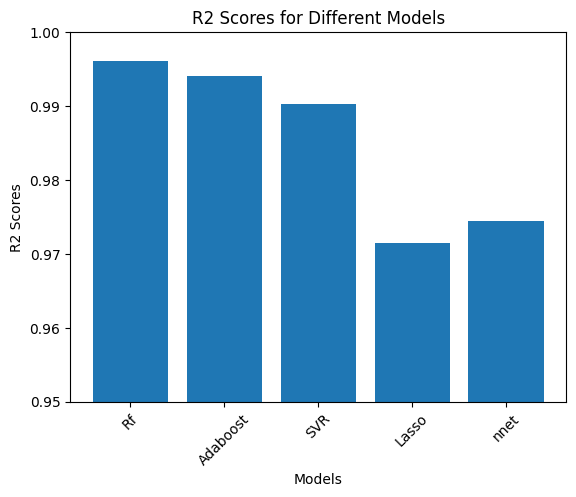

In [67]:
names = list(results2.keys())
scores = list(results2.values())

plt.bar(names, scores)
plt.xlabel('Models')
plt.ylabel('R2 Scores')
plt.title('R2 Scores for Different Models')
plt.xticks(rotation=45)
plt.ylim(0.95,1)
plt.show()

On observe que l'ajustement a vraiment été amélioré les performances de certains algorithmes. Dans l'ensemble, les algorithmes d'agrégation d'arbres semblent fonctionner le mieux, et montrent les meilleures performances. La régression par vecteurs de support fonctionne également un peu mieux sur les données complétées+dummies. La Regression Lasso et le perceptron multi-couche ne semblent pas bénéficier de l'ajout de données supplémentaires.